# Games Analysis

In this notebook we are conducting exploratory analysis on the graphs created from the data in `data/games/network_raw` and `data/games/network`. We are also using the metadata available in `data/games/metadata/all_games.csv`. List of questions that we aim to answer:

 * What kind of games do people play?
 * Do communities form around a series of games or a single game in a series?
 * Are there 'cliques' in speedrunning or are users more homogeneous?
 * What are the most popular games?
 * Do popular games have common properties?
 * Who makes the games that are the most 'speedrunnable'?
 * What differences are there between the most popular and least popular games?
 * How many games are there on speedrun.com?
 * How many games are *played* on speedrun.com?
 * Are there any issues with the data?
 * How should we deal with the issues in the data?
 * What are the statistics behind the different games on speedrun.com?
 

In [1]:
import csv
import collections
import random

import networkx as nx
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict, Counter
from datetime import datetime
from operator import itemgetter
from functools import reduce
from math import floor

In [2]:
FINAL_DATE = datetime(2023, 1, 1)

# Helper Functions

In [20]:
def generate_network_filter(filename: str, disallowed_games=None, allowed_games=None):
    with open(filename, 'r') as openfile:
        csv_reader = csv.reader(openfile)
        next(csv_reader)
        filter_map = defaultdict(bool)
        for row in csv_reader:
            # Check if the created/release date is after 2023, if it is then we can ignore it in the network.
            release_date = datetime.strptime(row[3], "%Y-%m-%d")
            if row[4] == "None":
                row[4] = "2017-10-22T05:21:29Z" # This is a completely random date before the final date.
            created_date = datetime.strptime(row[4], "%Y-%m-%dT%H:%M:%SZ")

            if disallowed_games == None:
                disallowed_games = ["y65797de"]

            if allowed_games == None:
                if created_date < FINAL_DATE and release_date < FINAL_DATE and row[0] not in disallowed_games:
                    filter_map[row[0]] = True
            else:
                if created_date < FINAL_DATE and release_date < FINAL_DATE and row[0] not in disallowed_games and row[0] in allowed_games:
                    filter_map[row[0]] = True

    return filter_map

def get_weighted_edges_from_csv(filename, filter=None):
    with open(filename, 'r') as openfile:
        csv_reader = csv.reader(openfile)
        next(csv_reader)

        edges = list()
        for row in csv_reader:
            if filter is None:
                edges.append(tuple([row[0], row[1], int(row[2])]))
                continue
            
            if not filter.get(row[0]) or not filter.get(row[1]):
                continue

            edges.append(tuple([row[0], row[1], int(row[2])]))

    return edges

def generate_graph_from_edges(edges_list):
    directed_graph = nx.DiGraph()
    directed_graph.add_weighted_edges_from(edges_list)
    return directed_graph

def save_weighted_graph(g: nx.DiGraph, filename: str):
    with open(filename, 'w', encoding='utf-8') as openfile:
        openfile.write("Source,Target,Weight\n")
        for source,target,data in g.edges(data=True):
            weight = int(data['weight'])
            output_string = ','.join(map(str, [source, target, weight]))
            openfile.write(f"{output_string}\n")

def get_centrality_from_file(filename: str) -> dict[str, float]:
    node_to_centrality = defaultdict(float)
    with open(filename, 'r', encoding='utf-8') as openfile:
        csv_reader = csv.reader(openfile)
        next(csv_reader)
        for row in csv_reader:
            node_to_centrality[row[0]] = float(row[1])

    return node_to_centrality

In [12]:
def rename_columns(df: pd.DataFrame):
    return df.rename(columns={
        'game_num_categories': 'num_categories',
        'game_num_levels': 'num_levels',
        'game_num_runs': 'num_runs',
        'game_num_users': 'num_users',
        'game_num_guests': 'num_guests',
        'game_created_date': 'created_date',
        'game_release_date': 'release_date',
    })

def format_games_metadata_dataframe(df: pd.DataFrame):
    df = rename_columns(df)
    # Remove row if game do not have a created date.
    df.drop(df[df['created_date'] == 'None'].index, inplace=True)
    
    # Remove rows with N/As in them.
    df = df.dropna()
    
    # Format the release_date and created_date to be an actual date type.
    df['release_date'] = pd.to_datetime(df['release_date'])
    df['created_date'] = pd.to_datetime(df['created_date'], format='%Y-%m-%dT%H:%M:%SZ')
    df['release_date'] = pd.to_datetime(df['release_date'].dt.strftime('%Y-%m-%d'))
    df['created_date'] = pd.to_datetime(df['created_date'].dt.strftime('%Y-%m-%d'))
    
    # Remove rows with a created date or release date before cutoff.
    df = df[(df['created_date'] < '2023-01-01') & (df['release_date'] < '2023-01-01')] 
    
    # Format numeric data into a numeric data type.
    df[['num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']] = df[['num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']].apply(pd.to_numeric)
    
    # Rename the game_id column to just id.
    df.rename(columns = {'game_id' : 'id'}, inplace=True)

    return df

In [4]:
def get_graph_order_size(g: nx.Graph):
    return g.order(), g.size()

# Exploratory Analysis

We are generating a network using the entire related games network that has been filtered using the previously mentioned function. This gives us a directed graph with **30,433 nodes**, and **14,739,311 edges**. Without filtering, we get a network that has **30,970 nodes** and **14,857,762 edges**. The filtering removes **537 nodes** and **118,451 edges**. The degree analysis of our network reveals a few insights. **The most popular node with respect to degree centrality is `k6q4rqzd` or Seterra**. We have also created a loglog plot of degree count. **What does this mean?**

Looking at the degrees with weights, the numbers are a little suspicious on some of the games. We can see that `Nerf Test Range` has the second highest in degree with weights value, despite having only 4844 runs. We can explain this with the following: A user that has played many games, but one game *far more* than the others, will show up many times in the edges going from all the games they have played. For example, if I play 4 games and in game 2 I have 1000 runs, then the edges of the network will be the following:

```
(1, 2) = 1000
(1, 3) = 2
(1, 4) = 4
(2, 1) = 1
(2, 3) = 1
(2, 4) = 1
(3, 1) = 1
(3, 2) = 1000
(3, 4) = 14
(4, 1) = 4
(4, 2) = 1000
(4, 3) = 2

in_degree_with_weight(2) = 3000
in_degree(2) = 3
out_degree_with_weight(2) = 1
out_degree(2) = 1
```

We can see that even though only one player has played game 2 it is by far the most popular looking at in degree with weights. This mean that we probably can't use this metric to define anything useful.

In [5]:
games_metadata_df = pd.read_csv('../data/raw/srcom_games_with_metadata.csv')
games_metadata_df[['game_num_categories', 'game_num_levels', 'game_num_runs', 'game_num_users', 'game_num_guests']] = games_metadata_df[['game_num_categories', 'game_num_levels', 'game_num_runs', 'game_num_users', 'game_num_guests']].apply(pd.to_numeric)
games_metadata_df.rename(columns = {'game_id': 'id'}, inplace=True)

In [6]:
games_metadata_df.describe(include='all', datetime_is_numeric=True)

,id,game_name,game_developers,game_release_date,game_created_date,game_num_categories,game_num_levels,game_num_runs,game_num_users,game_num_guests
count,32994,32994,32994,32994,32994,32994.000000,32994.000000,32994.000000,32994.000000,32994.000000
unique,32984,32960,8514,8589,32198,NaN,NaN,NaN,NaN,NaN
top,m1zkpq31,Dreams,None,2015-01-01,None,NaN,NaN,NaN,NaN,NaN
freq,2,3,18873,369,786,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,3.966115,7.046736,97.471934,20.651331,1.898891
std,NaN,NaN,NaN,NaN,NaN,4.397084,31.464601,686.818141,130.675756,89.318618
min,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,-999.000000,-999.000000,-999.000000
25%,NaN,NaN,NaN,NaN,NaN,2.000000,0.000000,3.000000,2.000000,0.000000
50%,NaN,NaN,NaN,NaN,NaN,3.000000,0.000000,10.000000,4.000000,0.000000
75%,NaN,NaN,NaN,NaN,NaN,5.000000,5.000000,39.000000,10.000000,0.000000


In [7]:
games_metadata_df.sum(numeric_only=True)

game_num_categories     130858
game_num_levels         232500
game_num_runs          3215989
game_num_users          681370
game_num_guests          62652
dtype: int64

In [8]:
games_metadata_df.sort_values(by='game_num_runs', ascending=False).head(10)

,id,game_name,game_developers,game_release_date,game_created_date,game_num_categories,game_num_levels,game_num_runs,game_num_users,game_num_guests
5162,k6q4rqzd,Seterra,"4eppvoer,ne410dem",1997-01-01,2018-09-27T08:29:37Z,29,903,61962,7168,36
16315,y65797de,Subway Surfers,None,2012-05-24,2017-06-25T17:41:20Z,13,0,39623,-999,-999
4924,o1y9wo6q,Super Mario 64,xv6dvx62,1996-06-23,None,6,15,33895,6118,452
23519,o1y9j9v6,Celeste,1zk4q26j,2018-01-25,2018-01-15T20:23:45Z,15,9,32317,5406,14
20434,w6jrzxdj,Speed Builders,None,2016-01-29,2017-03-03T03:33:28Z,1,2042,25083,261,9
16295,yd478gde,Minecraft: Legacy Console Edition,"yzom2keq,yge00xep",2012-05-09,2015-01-29T23:42:25Z,11,12,19379,155,15646
15794,j1npme6p,Minecraft: Java Edition,k62d97ex,2011-11-18,2015-01-29T23:41:21Z,15,0,18329,6268,491
23105,76r55vd8,Super Mario Odyssey,xv6dvx62,2017-10-27,2017-09-27T00:35:19Z,6,0,17212,3790,45
22979,o1y9pyk6,Google Snake,pe1wp36o,2017-09-27,2020-01-19T12:16:58Z,11,32,17105,4236,8
22350,46w0n91r,Mario Kart 8 Deluxe,xv6dvx62,2017-04-28,2017-04-30T00:26:59Z,10,0,15196,3046,20


In [9]:
games_metadata_df.sort_values(by='game_num_users', ascending=False).head(10)

,id,game_name,game_developers,game_release_date,game_created_date,game_num_categories,game_num_levels,game_num_runs,game_num_users,game_num_guests
5162,k6q4rqzd,Seterra,"4eppvoer,ne410dem",1997-01-01,2018-09-27T08:29:37Z,29,903,61962,7168,36
15794,j1npme6p,Minecraft: Java Edition,k62d97ex,2011-11-18,2015-01-29T23:41:21Z,15,0,18329,6268,491
4924,o1y9wo6q,Super Mario 64,xv6dvx62,1996-06-23,None,6,15,33895,6118,452
16941,pd0py36e,ROBLOX: Speed Run 4,yzol0kzq,2013-01-01,2015-10-14T00:39:39Z,9,33,11303,5636,20
23519,o1y9j9v6,Celeste,1zk4q26j,2018-01-25,2018-01-15T20:23:45Z,15,9,32317,5406,14
22528,m1z9l2d0,Hypixel BedWars,w63x8j6x,2017-06-21,2017-08-26T17:36:09Z,12,0,6597,4402,2349
15792,nd2e9erd,Minecraft: Java Edition Category Extensions,None,2011-11-18,2019-07-18T04:49:49Z,26,0,12116,4398,131
22979,o1y9pyk6,Google Snake,pe1wp36o,2017-09-27,2020-01-19T12:16:58Z,11,32,17105,4236,8
23105,76r55vd8,Super Mario Odyssey,xv6dvx62,2017-10-27,2017-09-27T00:35:19Z,6,0,17212,3790,45
32218,3698my8d,Roblox: DOORS,"nel4v162,v69vj9zx,yzov32eq",2022-08-11,2022-08-13T15:54:51Z,3,0,5360,3622,216


In [10]:
games_metadata_df.sort_values(by='game_num_guests', ascending=False).head(10)

,id,game_name,game_developers,game_release_date,game_created_date,game_num_categories,game_num_levels,game_num_runs,game_num_users,game_num_guests
16295,yd478gde,Minecraft: Legacy Console Edition,"yzom2keq,yge00xep",2012-05-09,2015-01-29T23:42:25Z,11,12,19379,155,15646
22528,m1z9l2d0,Hypixel BedWars,w63x8j6x,2017-06-21,2017-08-26T17:36:09Z,12,0,6597,4402,2349
26761,j1llrpz1,ROBLOX: Piggy,w63pvpzx,2020-01-23,2020-03-23T07:00:00Z,14,0,7382,2320,1321
17478,ldep0513,Final Fantasy XIV: Endwalker,qvegwk60,2013-08-24,2016-09-25T19:14:00Z,13,318,5290,926,1319
25719,yd4oq3k1,ROBLOX: Tower Defense Simulator,4zw7526k,2019-06-05,2020-03-25T15:16:10Z,13,49,6231,2825,1033
16764,3dx2r341,CubeCraft Games,None,2012-12-21,2020-05-10T00:11:49Z,12,127,3058,1049,842
23527,46w33wn1,Monster Hunter: World (Console),myzo3pzq,2018-01-26,2017-12-10T15:56:01Z,12,178,4373,296,688
28357,j1neozx1,Call of Duty: Black Ops Cold War Zombies,"myzo72eq,4rzj7nzl,5k62w6x2",2020-11-12,2020-11-12T21:20:23Z,7,0,3435,1912,663
22862,4d7y5zd7,Destiny 2,4ep8y76r,2017-09-06,2017-05-27T22:51:59Z,14,37,2395,1517,614
5981,j1l9qz1g,The Legend of Zelda: Ocarina of Time,xv6dvx62,1998-11-21,2015-02-17T01:43:13Z,12,12,8908,1224,586


In [13]:
formatted_games_metadata_df = format_games_metadata_dataframe(games_metadata_df.copy())
formatted_games_metadata_df.describe(include='all', datetime_is_numeric=True)

,id,game_name,game_developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests
count,31405,31405,31405,31405,31405,31405.000000,31405.000000,31405.000000,31405.000000,31405.000000
unique,31397,31376,8269,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,ldejp051,Dreams,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,2,3,17962,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,2009-12-04 13:57:32.583983616,2019-05-15 20:41:21.999681536,3.943894,7.026652,87.790288,19.164241,1.862793
min,NaN,NaN,NaN,1972-01-01 00:00:00,2014-11-30 00:00:00,0.000000,0.000000,0.000000,-999.000000,-999.000000
25%,NaN,NaN,NaN,2002-08-12 00:00:00,2017-03-20 00:00:00,2.000000,0.000000,3.000000,2.000000,0.000000
50%,NaN,NaN,NaN,2012-11-13 00:00:00,2019-09-07 00:00:00,3.000000,0.000000,10.000000,4.000000,0.000000
75%,NaN,NaN,NaN,2018-10-16 00:00:00,2021-08-15 00:00:00,5.000000,5.000000,37.000000,10.000000,0.000000
max,NaN,NaN,NaN,2022-12-25 00:00:00,2022-12-31 00:00:00,183.000000,2042.000000,61962.000000,7168.000000,15646.000000


In [14]:
n = 519
print(f"Difference between number of runs of top {n} games and 50% of all runs: {sum(formatted_games_metadata_df.sort_values(by='num_runs', ascending=False)['num_runs'][:n]) - (formatted_games_metadata_df['num_runs'].sum() // 2)}")
print(f"{(formatted_games_metadata_df.count()['id'] - n)/formatted_games_metadata_df.count()['id'] * 100:.2f}% of games have the same number of runs as the top {n/formatted_games_metadata_df.count()['id'] * 100:.2f}% of games")
n = 544
print(f"Difference between the number of users of top {n} games and 50% of all users: {sum(formatted_games_metadata_df.sort_values(by='num_users', ascending=False)['num_users'][:n]) - (formatted_games_metadata_df['num_users'].sum() // 2)}")
print(f"{(formatted_games_metadata_df.count()['id'] - n)/formatted_games_metadata_df.count()['id'] * 100:.2f}% of games have the same number of users as the top {n/formatted_games_metadata_df.count()['id'] * 100:.2f}% of games")


Difference between number of runs of top 519 games and 50% of all runs: -45
98.35% of games have the same number of runs as the top 1.65% of games
Difference between the number of users of top 544 games and 50% of all users: -25
98.27% of games have the same number of users as the top 1.73% of games


In [15]:
tmp_df = pd.DataFrame(columns=['num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests'], dtype=int)
tmp_df.loc['mean'] = round(formatted_games_metadata_df.mean(numeric_only=True), 0)
tmp_df.loc['std'] = round(formatted_games_metadata_df.std(numeric_only=True), 0)
tmp_df.loc['count', 'num_categories'] = formatted_games_metadata_df[(formatted_games_metadata_df['num_categories'] == round(formatted_games_metadata_df.mean(numeric_only=True)['num_categories'], 0))].count()['id']
tmp_df.loc['count', 'num_levels'] = formatted_games_metadata_df[(formatted_games_metadata_df['num_levels'] == round(formatted_games_metadata_df.mean(numeric_only=True)['num_levels'], 0))].count()['id']
tmp_df.loc['count', 'num_runs'] = formatted_games_metadata_df[(formatted_games_metadata_df['num_runs'] == round(formatted_games_metadata_df.mean(numeric_only=True)['num_runs'], 0))].count()['id']
tmp_df.loc['count', 'num_users'] = formatted_games_metadata_df[(formatted_games_metadata_df['num_users'] == round(formatted_games_metadata_df.mean(numeric_only=True)['num_users'], 0))].count()['id']
tmp_df.loc['count', 'num_guests'] = formatted_games_metadata_df[(formatted_games_metadata_df['num_guests'] == round(
    formatted_games_metadata_df.mean(numeric_only=True)['num_guests'], 0))].count()['id']
tmp_df

,num_categories,num_levels,num_runs,num_users,num_guests
mean,4.0,7.0,88.0,19.0,2.0
std,4.0,32.0,646.0,124.0,91.0
count,3786.0,384.0,36.0,227.0,922.0


In [16]:
formatted_games_metadata_df[
    (formatted_games_metadata_df['num_categories'] == round(formatted_games_metadata_df.mean(numeric_only=True)['num_categories'], 0)) &
    (formatted_games_metadata_df['num_levels'] == round(formatted_games_metadata_df.mean(numeric_only=True)['num_levels'], 0)) &
    (formatted_games_metadata_df['num_runs'] == round(formatted_games_metadata_df.mean(numeric_only=True)['num_runs'], 0)) &
    (formatted_games_metadata_df['num_users'] == round(formatted_games_metadata_df.mean(numeric_only=True)['num_users'], 0)) &
    (formatted_games_metadata_df['num_guests'] == round(formatted_games_metadata_df.mean(numeric_only=True)['num_guests'], 0))
]

,id,game_name,game_developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests


In [17]:
formatted_games_metadata_df[
    (formatted_games_metadata_df['num_categories'] == round(formatted_games_metadata_df.mean(numeric_only=True)['num_categories'], 0))
    # (formatted_games_metadata_df['num_levels'] == round(formatted_games_metadata_df.mean(numeric_only=True)['num_levels'], 0))
    # (formatted_games_metadata_df['num_runs'] == round(formatted_games_metadata_df.mean(numeric_only=True)['num_runs'], 0))
    # (formatted_games_metadata_df['num_users'] == round(formatted_games_metadata_df.mean(numeric_only=True)['num_users'], 0))
    # (formatted_games_metadata_df['num_guests'] == round(formatted_games_metadata_df.mean(numeric_only=True)['num_guests'], 0))
].sort_values(by='num_runs', ascending=False)

,id,game_name,game_developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests
20022,nd22xvd0,Refunct,ge0ry3ep,2015-10-16,2015-10-20,4,0,5669,1568,6
17873,369ep8dl,HiveMC DeathRun,None,2014-01-01,2016-01-12,4,46,4481,430,99
5799,9dokge1p,Banjo-Kazooie,5mzn8lzr,1998-06-29,2015-02-09,4,0,3309,392,65
19649,kdk5medm,BeamNG.drive,None,2015-05-29,2017-01-01,4,119,3085,650,1
24057,nd2e5yqd,ROBLOX: The CrusheR,None,2018-06-01,2019-01-28,4,184,2423,184,0
...,...,...,...,...,...,...,...,...,...,...
10974,4d79y0n1,Full Spectrum Warrior: Ten Hammers,None,2006-03-27,2020-12-16,4,0,0,0,0
32359,j1lqvev6,NBA 2K23,None,2022-09-09,2022-10-17,4,0,0,0,0
24134,46w2rq36,MOTHERGUNSHIP,None,2018-06-17,2021-07-31,4,0,0,0,0
6493,j1n84jw1,FreeSpace 2,yzod0keq,1999-09-30,2021-07-28,4,41,0,0,0


In [18]:
formatted_games_metadata_df.sum(numeric_only=True)

num_categories     123858
num_levels         220672
num_runs          2757054
num_users          601853
num_guests          58501
dtype: int64

In [21]:
filter_filename = "../data/raw/srcom_games_with_metadata.csv"
graph_filename = "../data/too_big/all_games.csv"
filter_map = generate_network_filter(filter_filename)
edges = get_weighted_edges_from_csv(graph_filename, filter=filter_map)
filtered_graph = generate_graph_from_edges(edges)
print(f"FILTERED: {get_graph_order_size(filtered_graph)}")

In [12]:
graph_filename = "../data/too_big/all_games.csv"
edges = get_weighted_edges_from_csv(graph_filename, filter=None)
unfiltered_graph = generate_graph_from_edges(edges)
print(f"UNFILTERED: {get_graph_order_size(unfiltered_graph)}")

UNFILTERED: (30972, 14857763)


In [ ]:
# Cleanup
del filter_filename, graph_filename, filter_map, edges, formatted_games_metadata_df

In [ ]:
nx.density(filtered_graph)

0.015914826973514384

In [12]:
out_degrees = pd.DataFrame(filtered_graph.out_degree()).rename(columns = {0: 'id', 1: 'out_degree'})
out_degrees_with_weight = pd.DataFrame(filtered_graph.out_degree(weight='weight')).rename(columns = {0: 'id', 1: 'out_degree_with_weight'})
in_degrees = pd.DataFrame(filtered_graph.in_degree()).rename(columns = {0: 'id', 1: 'in_degree'})
in_degrees_with_weight = pd.DataFrame(filtered_graph.in_degree(weight='weight')).rename(columns = {0: 'id', 1: 'in_degree_with_weight'})

In [13]:
games_metadata_df = pd.read_csv('../data/raw/srcom_games_with_metadata.csv')
games_metadata_df[['num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']] = games_metadata_df[['num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']].apply(pd.to_numeric)
games_metadata_df.rename(columns = {'game_id': 'id'}, inplace=True)

In [14]:
all_dataframes = [games_metadata_df, out_degrees, out_degrees_with_weight, in_degrees, in_degrees_with_weight]
degree_df = reduce(lambda left,right: pd.merge(left,right,on='id', how='inner'), all_dataframes)
del games_metadata_df, out_degrees, out_degrees_with_weight, in_degrees, in_degrees_with_weight
degree_df.describe()

,num_categories,num_levels,num_runs,num_users,num_guests,out_degree,out_degree_with_weight,in_degree,in_degree_with_weight
count,30440.000000,30440.000000,30440.000000,30440.000000,30440.000000,30440.000000,30440.000000,30440.000000,3.044000e+04
mean,4.055125,7.372208,103.919284,22.278581,2.077135,484.306078,2121.236958,484.306537,2.120896e+03
std,4.461197,32.478199,677.609514,135.789522,92.810672,869.869936,5361.872510,869.825237,2.138506e+04
min,1.000000,0.000000,-999.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,2.000000,0.000000,4.000000,2.000000,0.000000,26.000000,72.000000,26.000000,3.900000e+01
50%,3.000000,0.000000,12.000000,4.000000,0.000000,97.000000,310.500000,97.000000,1.840000e+02
75%,5.000000,5.000000,44.000000,11.000000,0.000000,416.000000,1530.000000,417.000000,1.040000e+03
max,183.000000,2042.000000,61962.000000,7168.000000,15646.000000,9206.000000,151023.000000,9211.000000,2.005087e+06


In [17]:
degree_df.sort_values(by='in_degree_with_weight', ascending=False).head(10)

,id,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests,out_degree,out_degree_with_weight,in_degree,in_degree_with_weight
4895,k6q4rqzd,Seterra,"4eppvoer,ne410dem",1997-01-01,2018-09-27T08:29:37Z,29,903,61962,7168,36,9206,151023,9211,2005087
18148,j1ne0vl1,Nerf Test Range,None,2015-01-01,2021-03-13T23:11:48Z,13,30,4844,43,0,4482,60028,4484,1643535
25802,nd285r3d,Catapult Quest,None,2020-06-18,2022-02-12T11:53:22Z,10,550,3478,24,1,4081,55002,4088,1093294
17543,w6jl9o5d,Final Fantasy Record Keeper,leqowy6w,2014-09-24,2018-04-02T05:08:04Z,15,645,1733,10,0,814,2758,815,967633
13192,3dx2j9y1,Angry Birds,None,2009-12-01,2017-11-13T02:19:32Z,20,274,2897,95,2,3099,22370,3102,840104
13887,j1ll47v1,ROBLOX: Longest Obby in Roblox | 1000+ Obstacl...,None,2010-10-13,2017-10-03T02:35:53Z,16,999,3354,71,1,3362,40458,3367,758797
17575,o1y7pv1q,White Tiles 4: Piano Master 2,3zym21z4,2014-10-03,2016-03-31T02:12:45Z,128,0,4829,225,7,5383,59243,5387,553313
15529,m1zjnrm6,Hill Climb Racing,v6dynp62,2012-09-22,2018-07-02T15:53:58Z,13,0,4253,180,2,3845,60035,3851,551302
26245,o1yj5n21,Perfect Golf - Satisfying Game,None,2020-09-08,2021-12-13T18:15:51Z,9,333,3103,31,0,4226,79892,4233,521378
24658,9dowpxm1,Gravity Box,None,2019-09-28,2019-10-08T09:01:33Z,3,268,2197,33,0,2982,51231,2987,487811


In [18]:
degree_df.sort_values(by='in_degree', ascending=False).head(10)

,id,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests,out_degree,out_degree_with_weight,in_degree,in_degree_with_weight
4895,k6q4rqzd,Seterra,"4eppvoer,ne410dem",1997-01-01,2018-09-27T08:29:37Z,29,903,61962,7168,36,9206,151023,9211,2005087
22112,o1y9j9v6,Celeste,1zk4q26j,2018-01-25,2018-01-15T20:23:45Z,15,9,32317,5406,14,7491,65403,7488,67573
4671,o1y9wo6q,Super Mario 64,xv6dvx62,1996-06-23,None,6,15,33895,6118,452,7294,101462,7302,64853
12755,k6q474zd,Minecraft (Classic),None,2009-05-17,2020-09-15T18:21:08Z,11,0,4563,2599,14,6850,89935,6855,45083
463,om1m3625,Super Mario Bros.,xv6dvx62,1985-09-13,None,5,0,8018,1737,31,6794,56136,6795,36025
21027,46w0n91r,Mario Kart 8 Deluxe,xv6dvx62,2017-04-28,2017-04-30T00:26:59Z,10,0,15196,3046,20,6683,60844,6696,75854
11462,9d3rv59d,Bee Movie Game (DS),81e7o2z7,2007-10-30,2019-08-01T15:40:10Z,2,0,236,221,3,6648,61961,6656,12970
10396,3dxz7p1y,New Super Mario Bros.,None,2006-05-15,2015-02-04T09:13:58Z,8,80,3787,708,20,6294,53153,6299,67495
1765,pd0wq31e,Super Mario World,xv6dvx62,1990-11-21,None,13,0,9820,1830,38,6288,46669,6293,38886
35,76rmo418,Pac-Man,None,1980-05-22,2016-09-27T00:08:16Z,4,0,331,143,4,6001,28759,6004,14677


In [19]:
degree_df.sort_values(by='out_degree', ascending=False).head(10)


,id,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests,out_degree,out_degree_with_weight,in_degree,in_degree_with_weight
4895,k6q4rqzd,Seterra,"4eppvoer,ne410dem",1997-01-01,2018-09-27T08:29:37Z,29,903,61962,7168,36,9206,151023,9211,2005087
22112,o1y9j9v6,Celeste,1zk4q26j,2018-01-25,2018-01-15T20:23:45Z,15,9,32317,5406,14,7491,65403,7488,67573
4671,o1y9wo6q,Super Mario 64,xv6dvx62,1996-06-23,None,6,15,33895,6118,452,7294,101462,7302,64853
12755,k6q474zd,Minecraft (Classic),None,2009-05-17,2020-09-15T18:21:08Z,11,0,4563,2599,14,6850,89935,6855,45083
463,om1m3625,Super Mario Bros.,xv6dvx62,1985-09-13,None,5,0,8018,1737,31,6794,56136,6795,36025
21027,46w0n91r,Mario Kart 8 Deluxe,xv6dvx62,2017-04-28,2017-04-30T00:26:59Z,10,0,15196,3046,20,6683,60844,6696,75854
11462,9d3rv59d,Bee Movie Game (DS),81e7o2z7,2007-10-30,2019-08-01T15:40:10Z,2,0,236,221,3,6648,61961,6656,12970
10396,3dxz7p1y,New Super Mario Bros.,None,2006-05-15,2015-02-04T09:13:58Z,8,80,3787,708,20,6294,53153,6299,67495
1765,pd0wq31e,Super Mario World,xv6dvx62,1990-11-21,None,13,0,9820,1830,38,6288,46669,6293,38886
35,76rmo418,Pac-Man,None,1980-05-22,2016-09-27T00:08:16Z,4,0,331,143,4,6001,28759,6004,14677


In [20]:
degree_df.sort_values(by='out_degree_with_weight', ascending=False).head(10)

,id,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests,out_degree,out_degree_with_weight,in_degree,in_degree_with_weight
4895,k6q4rqzd,Seterra,"4eppvoer,ne410dem",1997-01-01,2018-09-27T08:29:37Z,29,903,61962,7168,36,9206,151023,9211,2005087
4671,o1y9wo6q,Super Mario 64,xv6dvx62,1996-06-23,None,6,15,33895,6118,452,7294,101462,7302,64853
12755,k6q474zd,Minecraft (Classic),None,2009-05-17,2020-09-15T18:21:08Z,11,0,4563,2599,14,6850,89935,6855,45083
21613,o1y9pyk6,Google Snake,pe1wp36o,2017-09-27,2020-01-19T12:16:58Z,11,32,17105,4236,8,5367,80571,5374,112005
26245,o1yj5n21,Perfect Golf - Satisfying Game,None,2020-09-08,2021-12-13T18:15:51Z,9,333,3103,31,0,4226,79892,4233,521378
17697,j1n29w1p,Crossy Road,"leqvy2zw,leqj22zw",2014-11-20,2015-11-20T03:58:52Z,12,0,4905,1976,3,5411,75175,5426,60707
23170,369pxvg1,Google Minesweeper,None,2018-10-10,2020-07-11T10:00:59Z,2,0,3572,1696,0,4743,72947,4753,14735
23451,m1mnnojd,Factris,None,2018-12-09,2021-06-04T20:06:14Z,3,0,145,46,1,4706,69459,4712,23799
21733,76r55vd8,Super Mario Odyssey,xv6dvx62,2017-10-27,2017-09-27T00:35:19Z,6,0,17212,3790,45,5651,69281,5654,33511
11389,kdknmqdm,Freerice,None,2007-10-07,2017-04-01T06:10:43Z,20,0,787,82,0,5826,67686,5837,123312


In [21]:
in_degrees_with_weight = [d for n, d in filtered_graph.in_degree(weight='weight')]
in_degrees = [d for n, d in filtered_graph.in_degree()]
out_degrees_with_weight = [d for n, d in filtered_graph.out_degree(weight='weight')]
out_degrees = [d for n, d in filtered_graph.out_degree()]

In [22]:
in_degree_with_weights_counts = sorted(collections.Counter(in_degrees_with_weight).items(), key=itemgetter(1), reverse=True)
in_degree_counts = sorted(collections.Counter(in_degrees).items(), key=itemgetter(1), reverse=True)
out_degree_with_weights_counts = sorted(collections.Counter(out_degrees_with_weight).items(), key=itemgetter(1), reverse=True)
out_degree_counts = sorted(collections.Counter(out_degrees).items(), key=itemgetter(1), reverse=True)

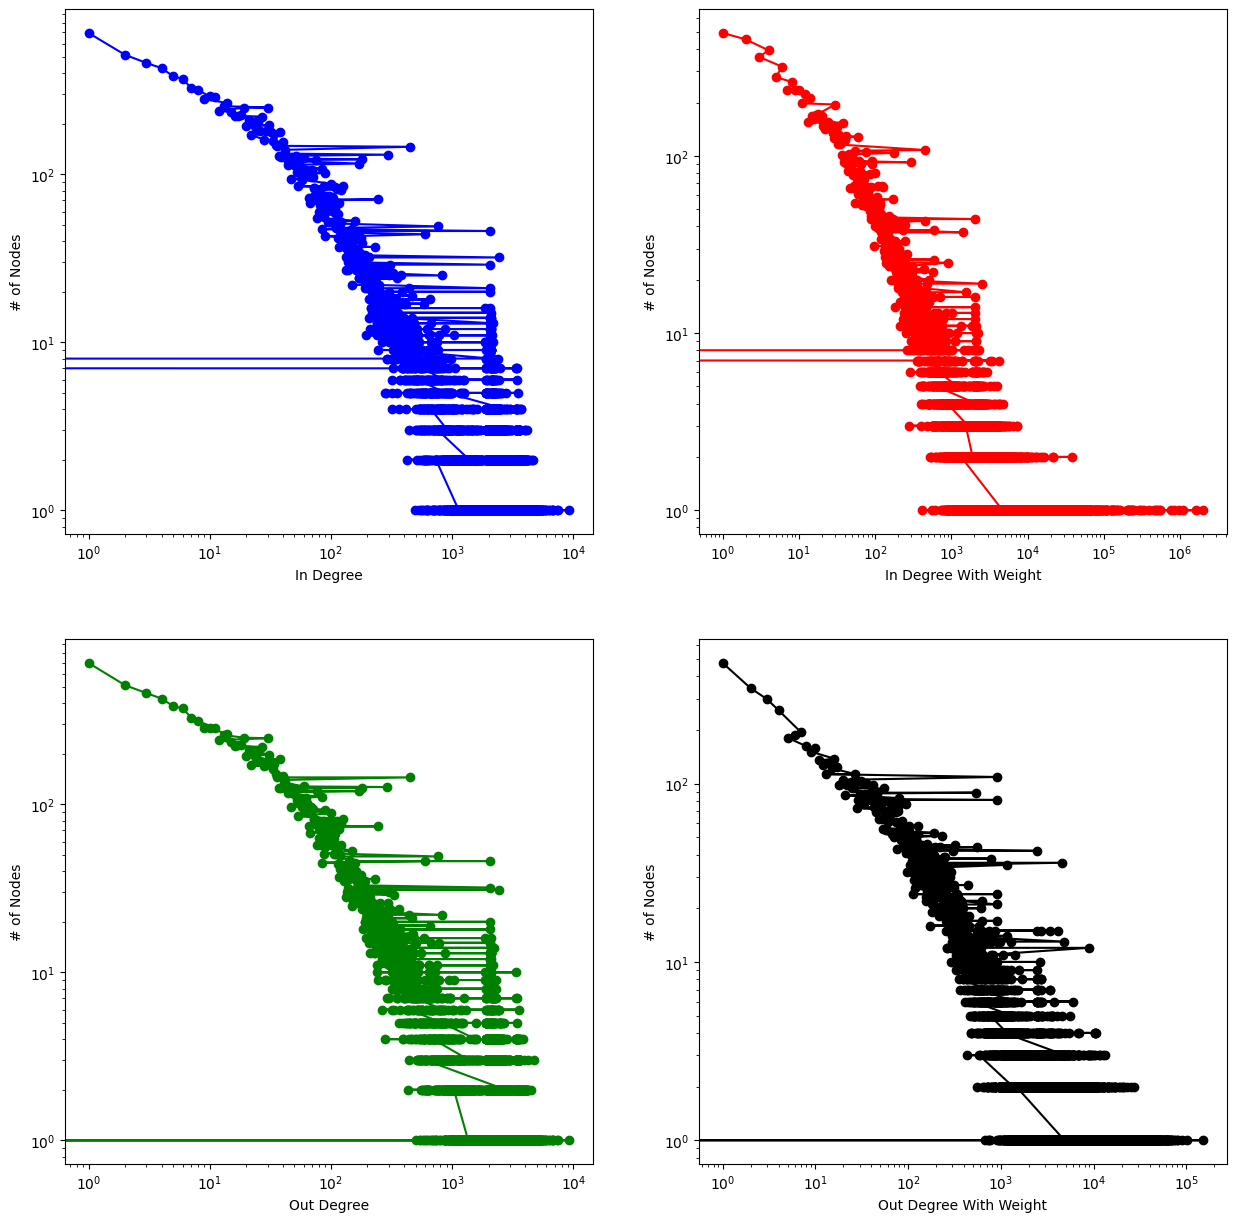

In [23]:
fig, ax = plt.subplots(2, 2)

x, y = list(zip(*in_degree_counts))
ax[0, 0].loglog(x, y,'bo-')
ax[0, 0].set_ylabel("# of Nodes")
ax[0, 0].set_xlabel("In Degree")

x, y = list(zip(*in_degree_with_weights_counts))
ax[0, 1].loglog(x, y, 'ro-')
ax[0, 1].set_ylabel("# of Nodes")
ax[0, 1].set_xlabel("In Degree With Weight")

x, y = list(zip(*out_degree_counts))
ax[1, 0].loglog(x, y,'go-')
ax[1, 0].set_ylabel("# of Nodes")
ax[1, 0].set_xlabel("Out Degree")

x, y = list(zip(*out_degree_with_weights_counts))
ax[1, 1].loglog(x, y, 'ko-')
ax[1, 1].set_ylabel("# of Nodes")
ax[1, 1].set_xlabel("Out Degree With Weight")

fig.set_figheight(15)
fig.set_figwidth(15)

plt.show()


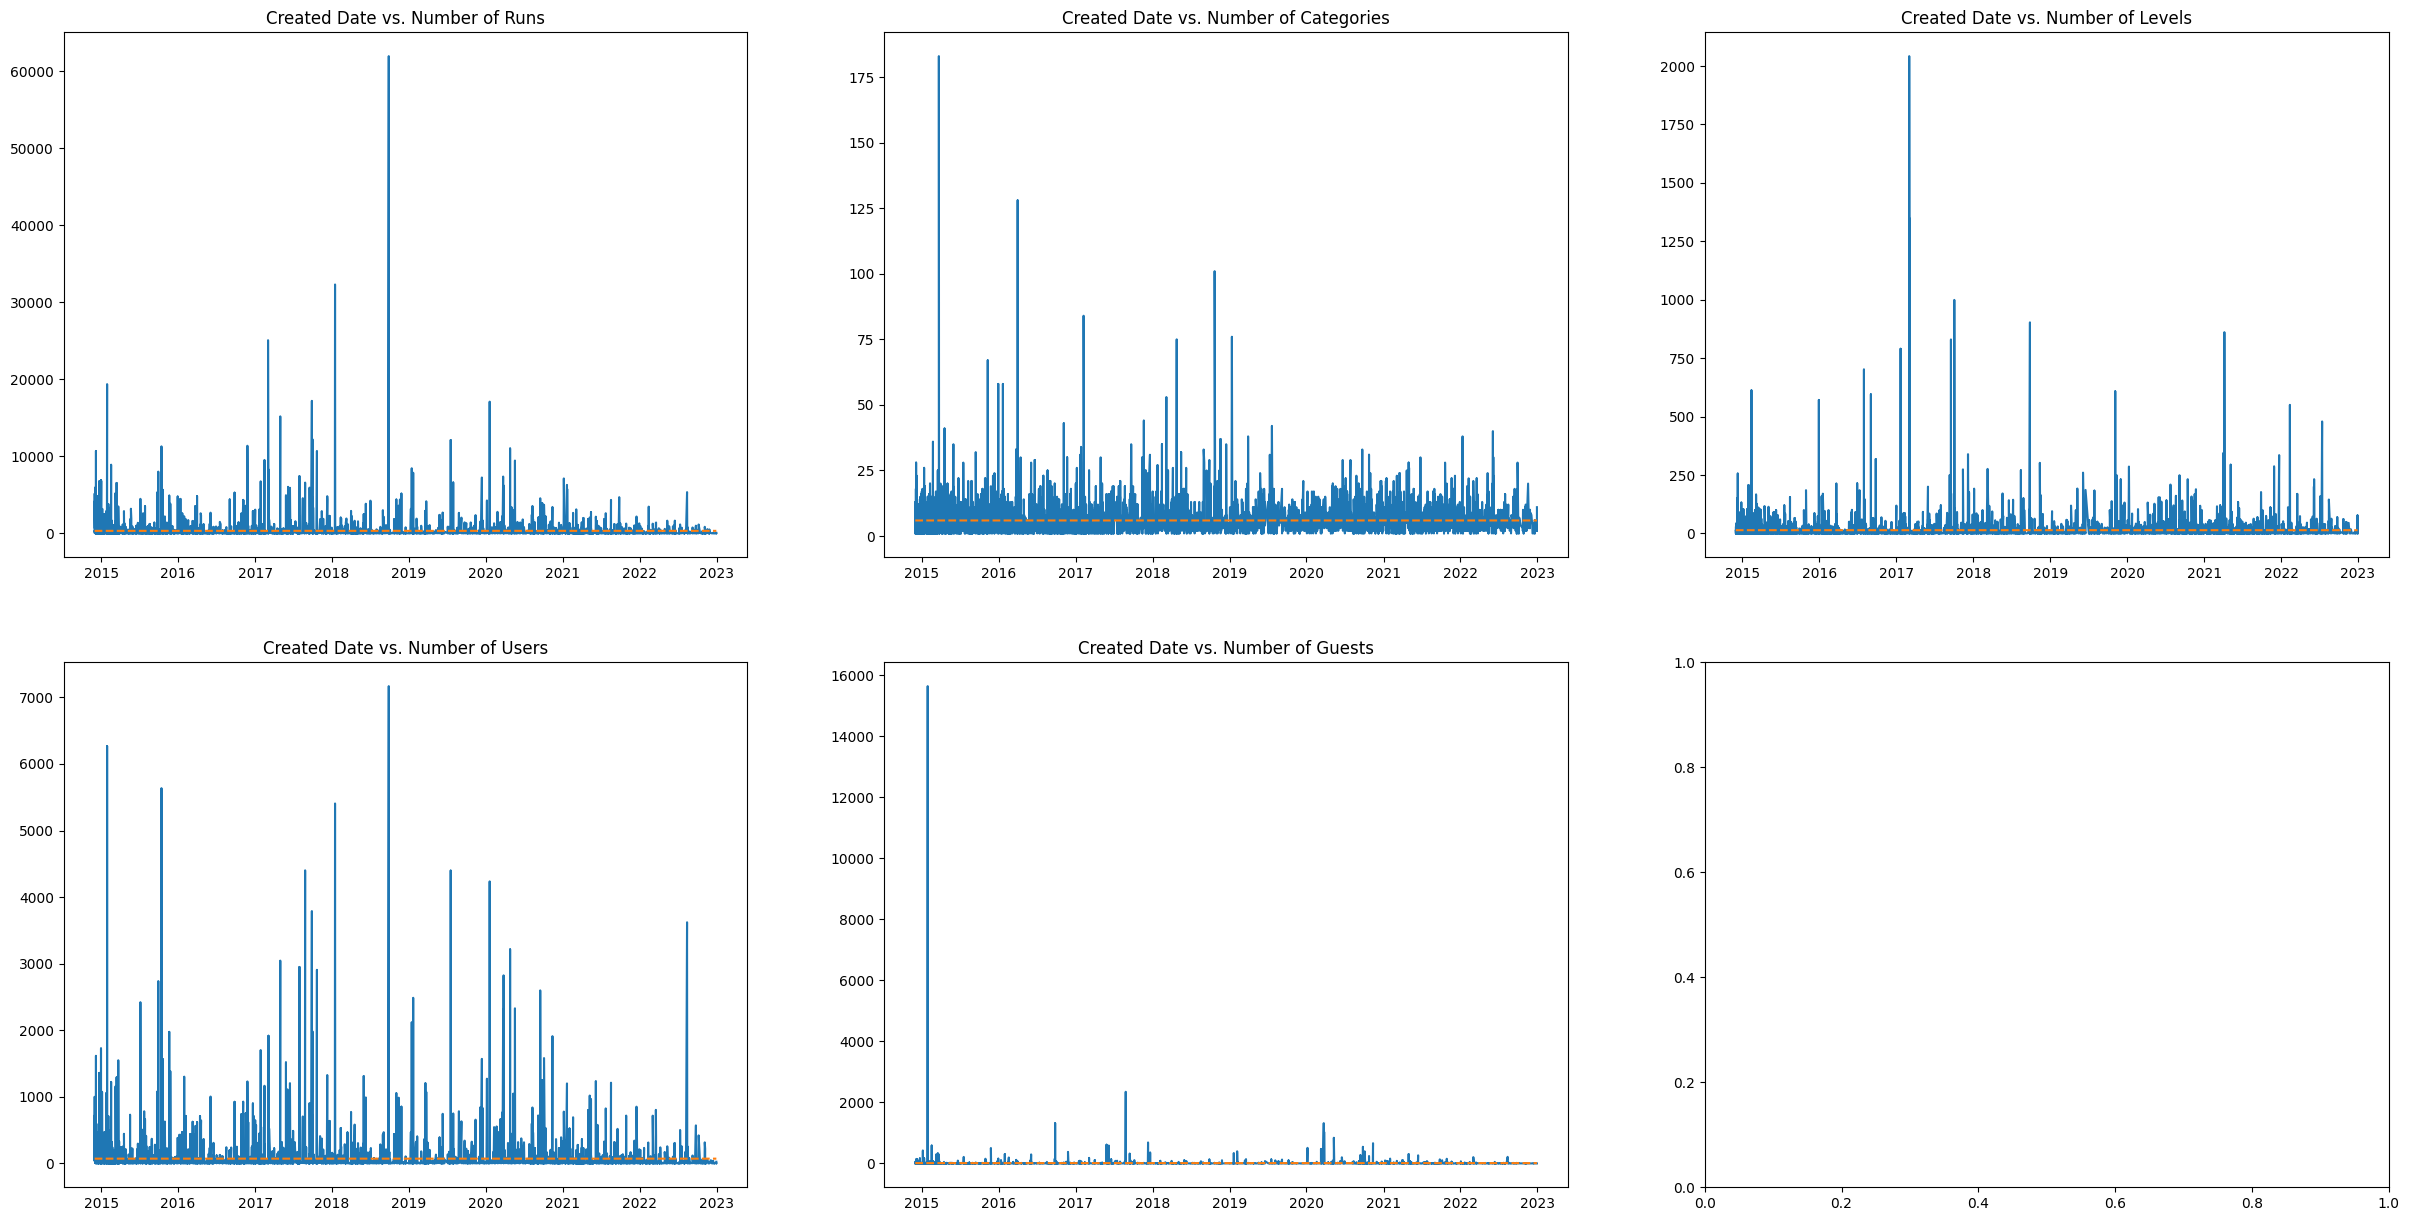

In [24]:
figure, axis = plt.subplots(2, 3)

df = format_games_metadata_dataframe(games_metadata_df).sort_values(by='created_date')
df = df[(df['num_users'] > 0) & (df['num_guests'] > 0)]
axis[0, 0].plot(df['created_date'], df['num_runs'])
mean = [np.mean(df['num_runs'])]*len(df['created_date'])
axis[0, 0].plot(df['created_date'], mean, linestyle='--')
axis[0, 0].set_title("Created Date vs. Number of Runs")

axis[0, 1].plot(df['created_date'], df['num_categories'])
mean = [np.mean(df['num_categories'])]*len(df['created_date'])
axis[0, 1].plot(df['created_date'], mean, linestyle='--')
axis[0, 1].set_title("Created Date vs. Number of Categories")

axis[0, 2].plot(df['created_date'], df['num_levels'])
mean = [np.mean(df['num_levels'])]*len(df['created_date'])
axis[0, 2].plot(df['created_date'], mean, linestyle='--')
axis[0, 2].set_title("Created Date vs. Number of Levels")

axis[1, 0].plot(df['created_date'], df['num_users'])
mean = [np.mean(df['num_users'])]*len(df['created_date'])
axis[1, 0].plot(df['created_date'], mean, linestyle='--')
axis[1, 0].set_title("Created Date vs. Number of Users")

axis[1, 1].plot(df['created_date'], df['num_guests'])
mean = [np.mean(df['num_guests'])]*len(df['created_date'])
axis[1, 1].plot(df['created_date'], mean, linestyle='--')
axis[1, 1].set_title("Created Date vs. Number of Guests")

df = df.sort_index()

figure.set_figwidth(30)
figure.set_figheight(15)

plt.show()

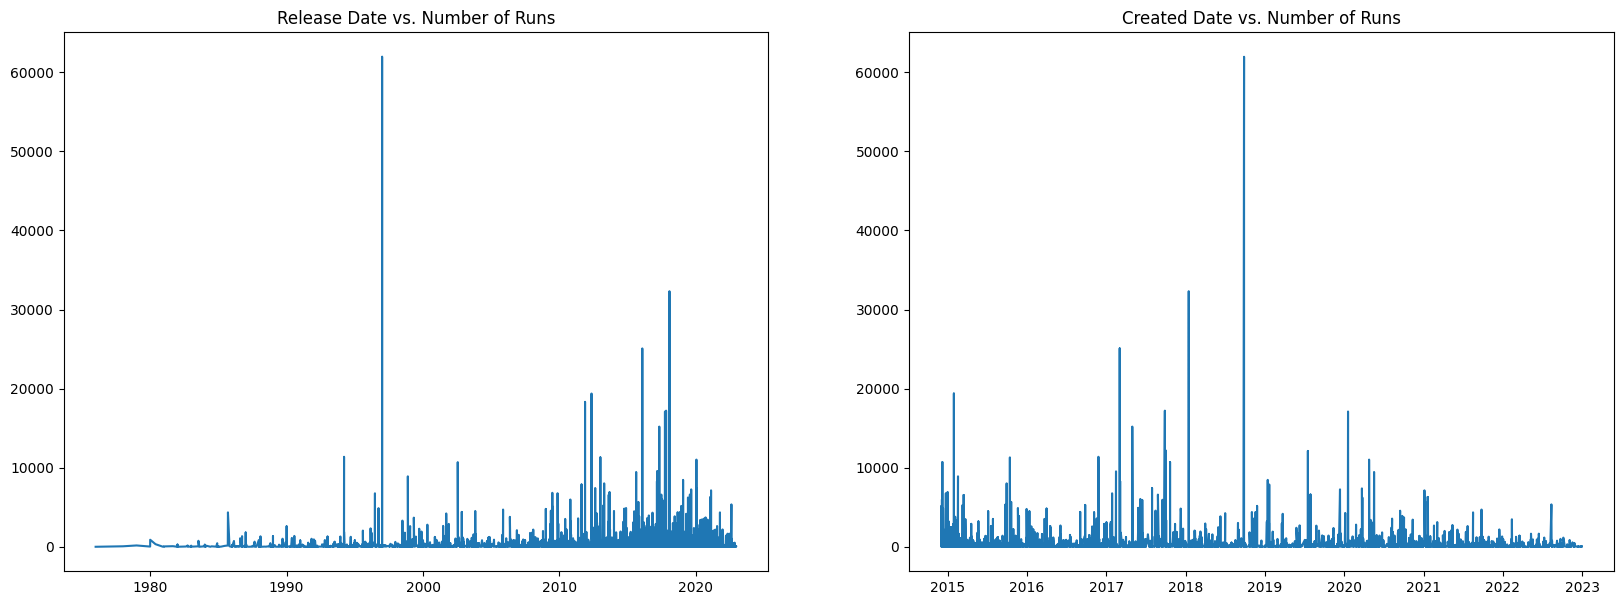

In [25]:
figure, axis = plt.subplots(1, 2)

df = df.sort_values(by='release_date')
axis[0].plot(df['release_date'], df['num_runs'])
axis[0].set_title("Release Date vs. Number of Runs")

df = df.sort_values(by='created_date')
axis[1].plot(df['created_date'], df['num_runs'])
axis[1].set_title("Created Date vs. Number of Runs")

df = df.sort_index()

figure.set_figwidth(20)
figure.set_figheight(7)

plt.show()

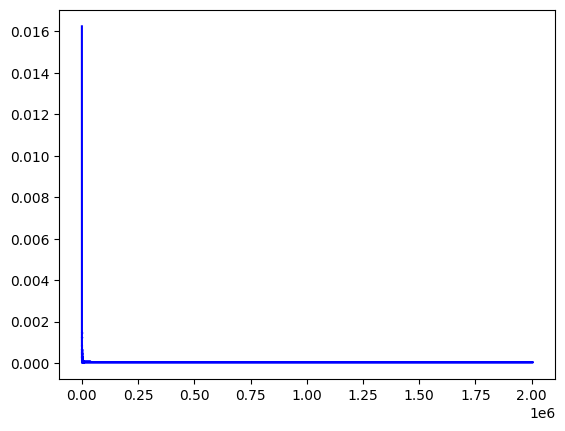

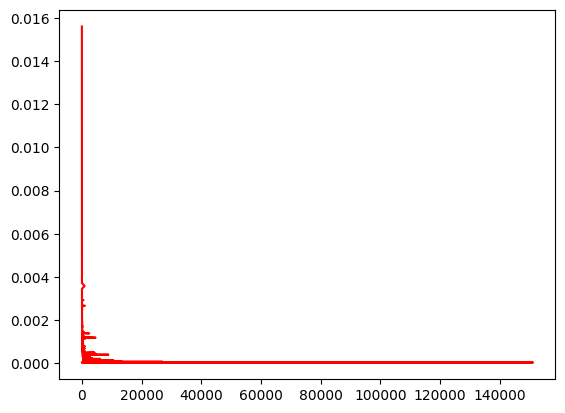

In [18]:
in_degree_dict = dict(filtered_graph.in_degree(weight='weight'))
in_degree_list = list(in_degree_dict.values())
in_degree_df = pd.DataFrame(in_degree_list, columns=['in_degree'])
in_degree_distribution = in_degree_df['in_degree'].value_counts(normalize=True).to_dict()
plt.plot(in_degree_distribution.keys(), in_degree_distribution.values(), 'b')
plt.show()

out_degree_dict = dict(filtered_graph.out_degree(weight='weight'))
out_degree_list = list(out_degree_dict.values())
out_degree_df = pd.DataFrame(out_degree_list, columns=['out_degree'])
out_degree_distribution = out_degree_df['out_degree'].value_counts(normalize=True).to_dict()
plt.plot(out_degree_distribution.keys(), out_degree_distribution.values(), 'r')
plt.show()

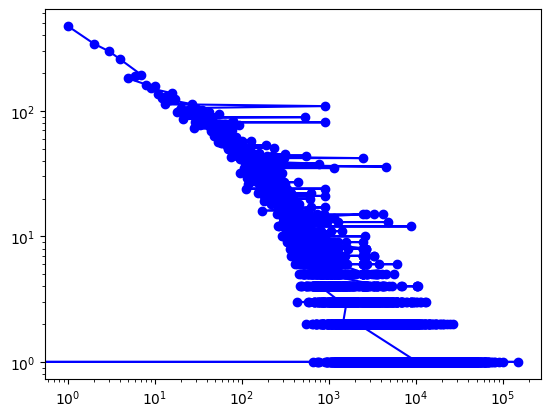

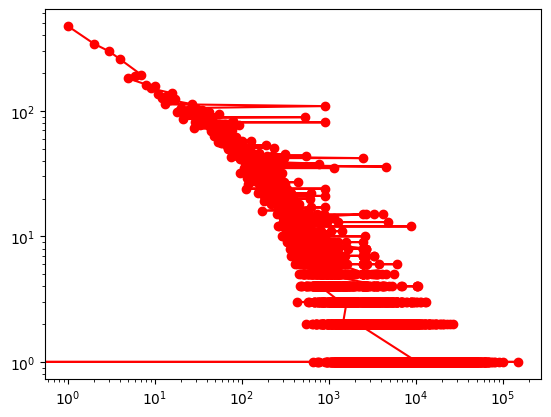

In [ ]:
in_degree_distribution = in_degree_df['in_degree'].value_counts(normalize=False).to_dict()
out_degree_distribution = out_degree_df['out_degree'].value_counts(normalize=False).to_dict()
plt.loglog(in_degree_distribution.keys(), in_degree_distribution.values(), 'bo-')
plt.show()
plt.loglog(out_degree_distribution.keys(), out_degree_distribution.values(), 'ro-')
plt.show()

In [ ]:
# Cleanup
del games_metadata_df, degree_df, all_dataframes, in_degrees_with_weight, in_degrees, out_degrees, out_degrees_with_weight, \
    in_degree_with_weights_counts, in_degree_counts, out_degree_counts, out_degree_with_weights_counts,  fig, ax, x, y

## Connected Components of the Games Network

The graph is composed of **38 weakly connect components** and **47 strongly connected components**. This means that instead of one large graph creating our network, we have several components that create the overall graph. Inspecting these components, we find one massive component and multiple incredibly small components. This means that **we have a main graph that is extremely well connected**, and **several disconnected sub-graphs**. This means that **the average player plays popular games that many other players have played**. We can inspect these small components and find that they are rare cycles where there are only a few players of a game, and those players have *only* played those games.  

In [27]:
print(f"IS WEAKLY CONNECTED: {nx.is_weakly_connected(filtered_graph)}")
print(f"IS STRONGLY CONNECTED: {nx.is_strongly_connected(filtered_graph)}")

IS WEAKLY CONNECTED: False
IS STRONGLY CONNECTED: False


In [28]:
print(f"NO. OF WEAKLY CONNECTED COMPONENTS: {nx.number_weakly_connected_components(filtered_graph)}")
print(f"NO. OF STRONGLY CONNECTED COMPONENTS: {nx.number_strongly_connected_components(filtered_graph)}")

NO. OF WEAKLY CONNECTED COMPONENTS: 38
NO. OF STRONGLY CONNECTED COMPONENTS: 47


In [29]:
weak_components = sorted([component for component in nx.weakly_connected_components(filtered_graph)], key=len, reverse=True)
strong_components = sorted([component for component in nx.strongly_connected_components(filtered_graph)], key=len, reverse=True)

largest_weak_component = len(max(weak_components, key=len))
largest_strong_component = len(max(strong_components, key=len))

print(f"Largest weak component: {largest_weak_component}\nLargest strong component: {largest_strong_component}")

Largest weak component: 30344
Largest strong component: 30335


In [30]:
games_metadata_df = pd.read_csv('../data/raw/srcom_games_with_metadata.csv')
games_metadata_df[['num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']] = games_metadata_df[['num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']].apply(pd.to_numeric)
games_metadata_df.rename(columns={'game_id': 'id'}, inplace=True)

In [31]:
games_list = weak_components[1]
games_metadata_df[(games_metadata_df['id'].isin(games_list))]

,id,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests
25061,m1zknp31,Sapporo Station 1980,None,2018-12-31,2021-10-15T01:03:23Z,4,0,1,1,0
26671,3698gv0d,Sapporo Station 2012,None,2019-12-31,2021-11-03T20:39:20Z,4,0,1,1,0
27231,pd0q7lv1,Sapporo Station 2020,None,2020-05-05,2021-11-03T20:38:11Z,4,0,1,1,0
29153,k6qw47x6,New Hokkaido 4000km,None,2021-03-22,2021-05-20T19:21:51Z,6,0,14,3,0
30998,ldej0wl1,Hokkaido 4500km,None,2021-12-31,2022-01-13T21:09:30Z,4,0,8,2,0


In [32]:
# Cleanup
del weak_components, strong_components, largest_weak_component, largest_strong_component, games_metadata_df, games_list

## Centrality Analysis

In this section we look at the various types of centrality: Closeness, Hyperlink-Induced Topic Search (Hits), Pagerank, and Betweenness. Centrality metrics recognise nodes that are important or central among the whole list of other nodes in a graph.

 * Degree Centrality: The higher the degree of the node, the more crucial it is to the graph. It is used to find popular nodes, most connected nodes, or nodes that hold the most information.
 * Closeness Centrality: A node's importance is based on how 'close' it is to all the other nodes in the graph. We define closeness as the number of edges between two nodes.
 * Hits Centrality: A good hub node represents a node that pointed to many other nodes, while a good authority node represents a node that is linked by many different hub nodes.
 * Pagerank Centrality: A node's importance is based on the direction of the edges connecting to/from a node.
 * Betweenness Centrality: A node's importance is based on the number of times it appears in the shortest paths between other nodes. It is essentially a percetage of nodes in the network that have that node in their shortest paths.

In [11]:
closeness_centrality_filename = "../data/processed/games/centrality/all_games_closeness_centrality.csv"
hits_centrality_filename = "../data/processed/games/centrality/all_games_hits_centrality.csv"
pagerank_filename = "../data/processed/games/centrality/all_games_pagerank.csv"
betweenness_centrality_filename = "../data/processed/games/centrality/all_games_betweenness_centrality.csv"

closeness_centrality_df = pd.read_csv(closeness_centrality_filename).rename(columns = {'value': 'closeness_value'})
hits_centrality_df = pd.read_csv(hits_centrality_filename)
pagerank_df = pd.read_csv(pagerank_filename).rename(columns = {'value': 'pagerank_value'})
betweenness_centrality_df = pd.read_csv(betweenness_centrality_filename).rename(columns = {'value': 'betweenness_value'})

games_metadata_df = pd.read_csv('../data/raw/srcom_games_with_metadata.csv')
games_metadata_df[['num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']] = games_metadata_df[['num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']].apply(pd.to_numeric)
games_metadata_df.rename(columns={'game_id': 'id'}, inplace=True)

In [12]:
all_dataframes = [games_metadata_df, closeness_centrality_df, hits_centrality_df, pagerank_df, betweenness_centrality_df]
merged_df = reduce(lambda left,right: pd.merge(left,right,on='id'), all_dataframes)
merged_df.describe(include='all')

,id,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests,closeness_value,authority_value,hub_value,pagerank_value,betweenness_value
count,30440,30440,30440,30440,30440,30440.000000,30440.000000,30440.000000,30440.000000,30440.000000,30439.000000,3.044000e+04,3.044000e+04,30440.000000,3.044000e+04
unique,30433,30414,7886,8317,29654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,v1pxwk86,Dreams,None,2015-01-01,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,2,3,17222,357,779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,4.055125,7.372208,103.919284,22.278581,2.077135,0.319274,3.461664e-04,1.363310e-03,0.000033,5.611297e-05
std,NaN,NaN,NaN,NaN,NaN,4.461197,32.478199,677.609514,135.789522,92.810672,0.049550,5.721256e-03,5.567596e-03,0.000205,2.735144e-04
min,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,-999.000000,0.000000,0.000000,0.006737,0.000000e+00,0.000000e+00,0.000005,0.000000e+00
25%,NaN,NaN,NaN,NaN,NaN,2.000000,0.000000,4.000000,2.000000,0.000000,0.295556,5.467181e-07,1.721085e-07,0.000007,5.762778e-08
50%,NaN,NaN,NaN,NaN,NaN,3.000000,0.000000,12.000000,4.000000,0.000000,0.317954,4.130517e-06,1.949215e-06,0.000011,3.268143e-06
75%,NaN,NaN,NaN,NaN,NaN,5.000000,5.000000,44.000000,11.000000,0.000000,0.344057,3.769929e-05,9.420492e-05,0.000025,3.254986e-05


<Axes: >

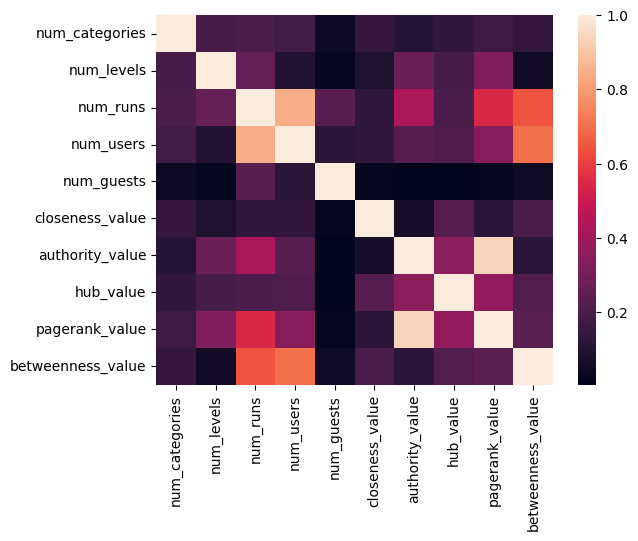

In [13]:
sns.heatmap(merged_df.corr())

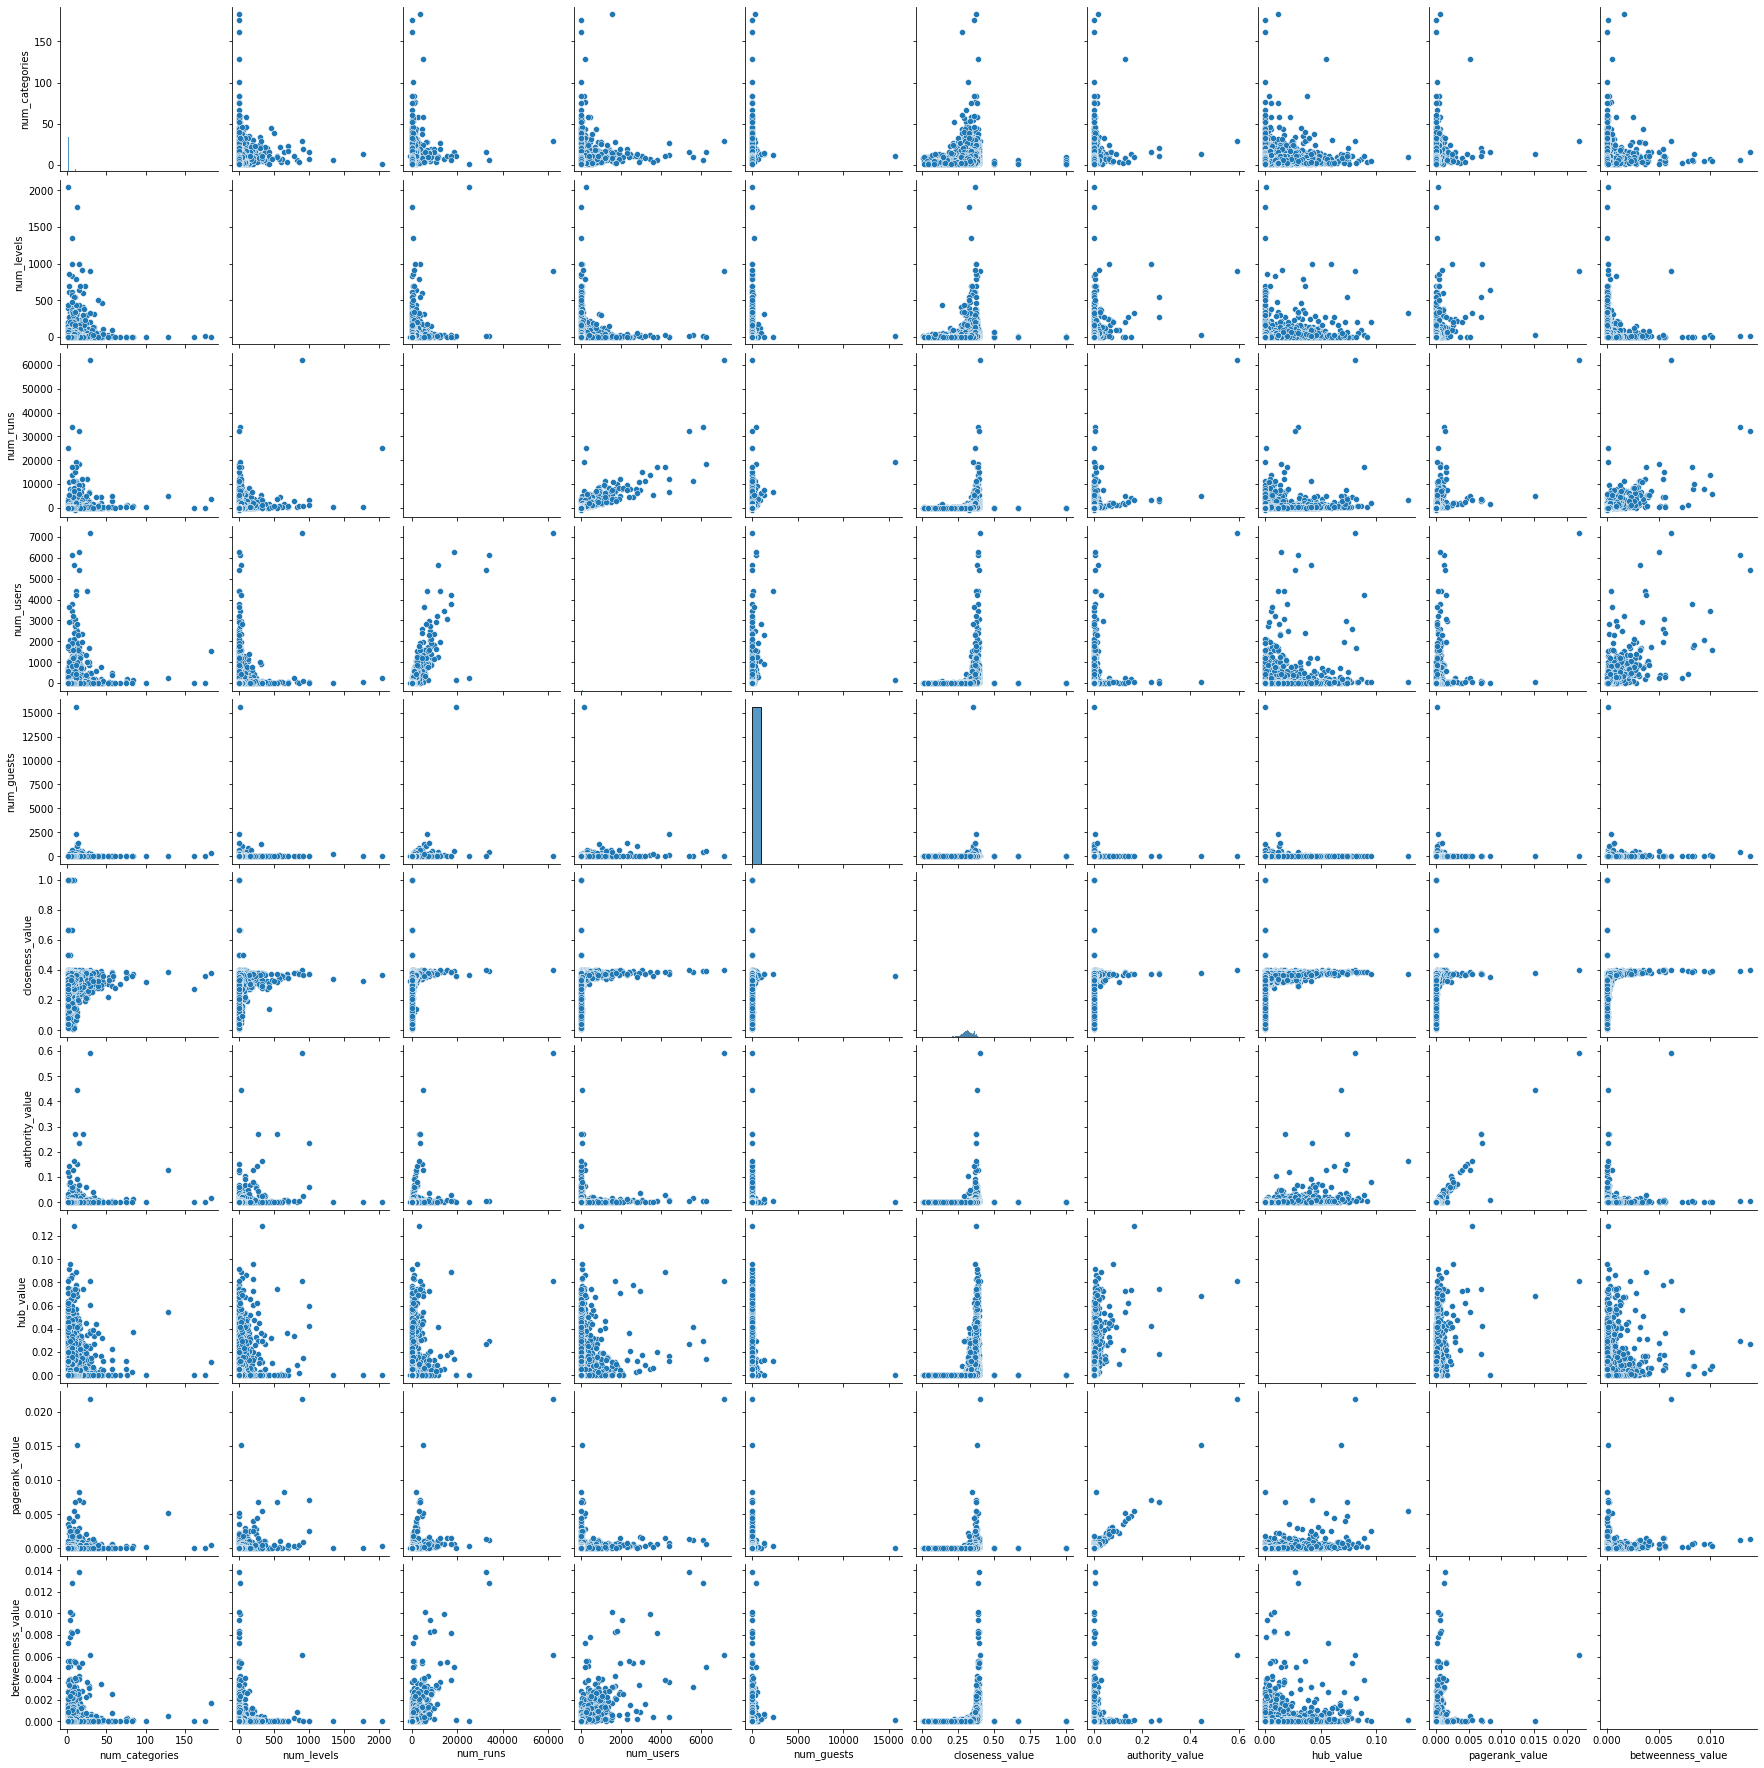

In [37]:
sns.pairplot(merged_df)

In [14]:
tmp_df = merged_df.groupby(['developers'])
grouped_merged_df = tmp_df.sum(numeric_only=True)
grouped_merged_df['num_games_per_developer'] = tmp_df.count().iloc[:, 0]
del tmp_df

### Closeness Centrality

In [15]:
top_n_values = 10
merged_df.sort_values(by="closeness_value", ascending=False).tail(top_n_values)

,id,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests,closeness_value,authority_value,hub_value,pagerank_value,betweenness_value
4826,w6jlx2ed,Daikoukai Jidai III,v6d4xx62,1996-11-29,2020-02-15T13:25:42Z,1,0,3,1,1,0.028947,1.312972e-13,1.367798e-11,0.000005,0.0
5936,o6glmpxd,Heroes of Might and Magic III: In-Game Days,None,1999-03-03,2021-01-11T23:17:46Z,9,10,13,1,0,0.028600,1.657712e-09,1.180753e-08,0.000007,0.0
15106,3dx24341,Heroes of Might and Magic III: Horn of the Abyss,None,2012-01-01,2020-09-25T14:13:58Z,8,1,10,1,0,0.028600,1.275163e-09,1.180763e-08,0.000007,0.0
6956,o1y9vj26,DOVE,None,2001-01-01,2020-11-01T16:16:18Z,2,10,19,1,0,0.025691,1.412394e-09,7.025734e-08,0.000006,0.0
26492,9d38wje1,Tiny Toy Tanks,None,2020-10-25,2021-07-25T15:46:00Z,2,0,2,2,0,0.019180,1.074341e-08,3.622988e-08,0.000005,0.0
28064,yd4k0kk6,Dark Roll: Free Kick Challenge,None,2021-08-05,2021-09-16T18:07:52Z,1,0,8,3,0,0.016969,6.777964e-10,1.293167e-08,0.000005,0.0
24301,nd28wxed,Sky: Children of the Light Category Extensions,4nel1l62,2019-07-18,2021-08-28T16:03:20Z,9,0,3,5,0,0.016428,6.602013e-07,6.508087e-07,0.000005,0.0
23787,pdv2q8v6,KDA Fan Game,rzj1rpzl,2019-02-26,2022-11-09T16:29:58Z,4,4,61,5,0,0.014984,3.933716e-09,6.207582e-08,0.000006,0.0
9047,3dxkz2y1,Homecoming: City of Heroes Incarnate Trials,"pe11o3eo,1zkw02zj",2004-04-28,2021-08-09T17:57:45Z,8,8,8,1,0,0.006737,1.487012e-13,5.502745e-12,0.000010,0.0
10818,o1y9err6,Puyo Puyo 15th Anniversary,None,2006-12-14,2020-12-15T01:22:40Z,1,0,11,4,0,NaN,4.107427e-06,0.000000e+00,0.000008,0.0


In [16]:
closeness_df = grouped_merged_df.copy()
closeness_df['average_closeness_value'] = closeness_df['hub_value'] / closeness_df['num_games_per_developer']
closeness_df[['average_closeness_value', 'closeness_value', 'num_games_per_developer']].sort_values(by="average_closeness_value", ascending=False).head(top_n_values)

,average_closeness_value,closeness_value,num_games_per_developer
developers,,,
pe1wp36o,0.088676,0.384508,1
pe13wyzo,0.086131,0.385652,1
"4eppvoer,ne410dem",0.081210,0.401198,1
"yz8jyq6w,ge0x5pep,p6xr8261",0.074356,0.387514,1
4epx73zr,0.072942,0.381256,1
"leqvy2zw,leqj22zw",0.070711,0.386522,1
ge0g936p,0.069493,0.385441,1
leqmdqzw,0.067224,0.382453,1
v6dynp62,0.062585,0.746120,2


### Hubs and Authorities Centrality

In [17]:
merged_df.sort_values(by="hub_value", ascending=False).head(15)

,id,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests,closeness_value,authority_value,hub_value,pagerank_value,betweenness_value
26245,o1yj5n21,Perfect Golf - Satisfying Game,None,2020-09-08,2021-12-13T18:15:51Z,9,333,3103,31,0,0.375387,0.164470,0.128835,0.005509,0.000090
28973,9do8lpk1,Maze (Coolmath Games),None,2022-01-01,2022-07-19T14:20:27Z,4,200,2133,55,0,0.371184,0.078550,0.095686,0.002526,0.000022
23451,m1mnnojd,Factris,None,2018-12-09,2021-06-04T20:06:14Z,3,0,145,46,1,0.383090,0.005934,0.091759,0.000248,0.000153
21613,o1y9pyk6,Google Snake,pe1wp36o,2017-09-27,2020-01-19T12:16:58Z,11,32,17105,4236,8,0.384508,0.027298,0.088676,0.001578,0.003797
19294,4d790zr1,Tomb of the Mask,pe13wyzo,2016-02-19,2018-05-27T19:18:48Z,7,100,703,206,0,0.385652,0.008909,0.086131,0.000412,0.000772
20320,j1n07edp,Super Cat Bros.,ne4k096m,2016-11-17,2017-07-31T02:04:51Z,5,54,615,64,1,0.384679,0.018702,0.083844,0.000773,0.000121
18542,nd283med,Brain It On!,None,2015-06-25,2022-07-05T01:30:35Z,3,200,667,40,0,0.376622,0.010973,0.082741,0.000451,0.000094
23170,369pxvg1,Google Minesweeper,None,2018-10-10,2020-07-11T10:00:59Z,2,0,3572,1696,0,0.386418,0.003115,0.081525,0.000192,0.002198
4895,k6q4rqzd,Seterra,"4eppvoer,ne410dem",1997-01-01,2018-09-27T08:29:37Z,29,903,61962,7168,36,0.401198,0.593570,0.081210,0.021878,0.006154
12755,k6q474zd,Minecraft (Classic),None,2009-05-17,2020-09-15T18:21:08Z,11,0,4563,2599,14,0.392128,0.008157,0.077946,0.000603,0.005431


In [18]:
merged_df.sort_values(by="authority_value", ascending=False).head(15)

,id,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests,closeness_value,authority_value,hub_value,pagerank_value,betweenness_value
4895,k6q4rqzd,Seterra,"4eppvoer,ne410dem",1997-01-01,2018-09-27T08:29:37Z,29,903,61962,7168,36,0.401198,0.593570,0.081210,0.021878,6.153765e-03
18148,j1ne0vl1,Nerf Test Range,None,2015-01-01,2021-03-13T23:11:48Z,13,30,4844,43,0,0.382091,0.445458,0.068188,0.015118,6.654527e-05
13192,3dx2j9y1,Angry Birds,None,2009-12-01,2017-11-13T02:19:32Z,20,274,2897,95,2,0.377780,0.271052,0.018274,0.006820,1.587748e-04
25802,nd285r3d,Catapult Quest,None,2020-06-18,2022-02-12T11:53:22Z,10,550,3478,24,1,0.375735,0.270346,0.074065,0.006812,9.026303e-05
13887,j1ll47v1,ROBLOX: Longest Obby in Roblox | 1000+ Obstacl...,None,2010-10-13,2017-10-03T02:35:53Z,16,999,3354,71,1,0.372519,0.236636,0.042675,0.007070,6.963308e-05
26245,o1yj5n21,Perfect Golf - Satisfying Game,None,2020-09-08,2021-12-13T18:15:51Z,9,333,3103,31,0,0.375387,0.164470,0.128835,0.005509,9.046502e-05
15529,m1zjnrm6,Hill Climb Racing,v6dynp62,2012-09-22,2018-07-02T15:53:58Z,13,0,4253,180,2,0.372794,0.152589,0.073545,0.004682,7.719114e-05
24658,9dowpxm1,Gravity Box,None,2019-09-28,2019-10-08T09:01:33Z,3,268,2197,33,0,0.363585,0.142831,0.061883,0.004469,5.445706e-06
17575,o1y7pv1q,White Tiles 4: Piano Master 2,3zym21z4,2014-10-03,2016-03-31T02:12:45Z,128,0,4829,225,7,0.388771,0.127075,0.054620,0.005240,5.175375e-04
24481,9do84qm1,Infinite Arrow,None,2019-08-26,2022-01-09T20:48:33Z,8,200,1564,21,0,0.376570,0.126786,0.072173,0.004008,4.391604e-09


In [30]:
hub_df = grouped_merged_df.copy()
hub_df['average_hub_value'] = hub_df['hub_value'] / hub_df['num_games_per_developer']
hub_df[['average_hub_value', 'hub_value', 'num_games_per_developer']].sort_values(by="average_hub_value", ascending=False).head(top_n_values)

,average_hub_value,hub_value,num_games_per_developer
developers,,,
pe1wp36o,0.088676,0.088676,1
pe13wyzo,0.086131,0.086131,1
"4eppvoer,ne410dem",0.081210,0.081210,1
"yz8jyq6w,ge0x5pep,p6xr8261",0.074356,0.074356,1
4epx73zr,0.072942,0.072942,1
"leqvy2zw,leqj22zw",0.070711,0.070711,1
ge0g936p,0.069493,0.069493,1
leqmdqzw,0.067224,0.067224,1
v6dynp62,0.062585,0.125169,2


In [31]:
authority_hub = grouped_merged_df.copy()
authority_hub['average_authority_value'] = authority_hub['authority_value'] / authority_hub['num_games_per_developer']
authority_hub[['average_authority_value', 'authority_value', 'num_games_per_developer']].sort_values(by="average_authority_value", ascending=False).head(top_n_values)

,average_authority_value,authority_value,num_games_per_developer
developers,,,
"4eppvoer,ne410dem",0.593570,0.593570,1
3zym21z4,0.127075,0.127075,1
v6dynp62,0.109588,0.219176,2
nelk8vz2,0.067991,0.067991,1
ne4vq1em,0.063301,0.063301,1
yz8lo3ew,0.045572,0.045572,1
qe5g4pzv,0.042818,0.042818,1
4epx73zr,0.036867,0.036867,1
pe1wp36o,0.027298,0.027298,1


### Pagerank

In [19]:
merged_df.sort_values(by="pagerank_value", ascending=False).head(20)

,id,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests,closeness_value,authority_value,hub_value,pagerank_value,betweenness_value
4895,k6q4rqzd,Seterra,"4eppvoer,ne410dem",1997-01-01,2018-09-27T08:29:37Z,29,903,61962,7168,36,0.401198,0.593570,0.081210,0.021878,6.153765e-03
18148,j1ne0vl1,Nerf Test Range,None,2015-01-01,2021-03-13T23:11:48Z,13,30,4844,43,0,0.382091,0.445458,0.068188,0.015118,6.654527e-05
17543,w6jl9o5d,Final Fantasy Record Keeper,leqowy6w,2014-09-24,2018-04-02T05:08:04Z,15,645,1733,10,0,0.350139,0.007365,0.000073,0.008205,2.928286e-06
13887,j1ll47v1,ROBLOX: Longest Obby in Roblox | 1000+ Obstacl...,None,2010-10-13,2017-10-03T02:35:53Z,16,999,3354,71,1,0.372519,0.236636,0.042675,0.007070,6.963308e-05
13192,3dx2j9y1,Angry Birds,None,2009-12-01,2017-11-13T02:19:32Z,20,274,2897,95,2,0.377780,0.271052,0.018274,0.006820,1.587748e-04
25802,nd285r3d,Catapult Quest,None,2020-06-18,2022-02-12T11:53:22Z,10,550,3478,24,1,0.375735,0.270346,0.074065,0.006812,9.026303e-05
26245,o1yj5n21,Perfect Golf - Satisfying Game,None,2020-09-08,2021-12-13T18:15:51Z,9,333,3103,31,0,0.375387,0.164470,0.128835,0.005509,9.046502e-05
17575,o1y7pv1q,White Tiles 4: Piano Master 2,3zym21z4,2014-10-03,2016-03-31T02:12:45Z,128,0,4829,225,7,0.388771,0.127075,0.054620,0.005240,5.175375e-04
15529,m1zjnrm6,Hill Climb Racing,v6dynp62,2012-09-22,2018-07-02T15:53:58Z,13,0,4253,180,2,0.372794,0.152589,0.073545,0.004682,7.719114e-05
24658,9dowpxm1,Gravity Box,None,2019-09-28,2019-10-08T09:01:33Z,3,268,2197,33,0,0.363585,0.142831,0.061883,0.004469,5.445706e-06


In [33]:
pagerank_df = grouped_merged_df.copy()
pagerank_df['average_pagerank_value'] = pagerank_df['pagerank_value'] / pagerank_df['num_games_per_developer']
pagerank_df[['average_pagerank_value', 'pagerank_value', 'num_games_per_developer']].sort_values(by="average_pagerank_value", ascending=False).head(top_n_values)

,average_pagerank_value,pagerank_value,num_games_per_developer
developers,,,
"4eppvoer,ne410dem",0.021878,0.021878,1
3zym21z4,0.005240,0.005240,1
v6dynp62,0.003640,0.007279,2
nelk8vz2,0.002938,0.002938,1
ne4vq1em,0.002830,0.002830,1
leqowy6w,0.002741,0.008224,3
yz8lo3ew,0.001842,0.001842,1
4epx73zr,0.001676,0.001676,1
pe1wp36o,0.001578,0.001578,1


### Betweenness Centrality

In [18]:
merged_df.sort_values(by="betweenness_value", ascending=False).head(20)

,id,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests,closeness_value,authority_value,hub_value,pagerank_value,betweenness_value
22112,o1y9j9v6,Celeste,1zk4q26j,2018-01-25,2018-01-15T20:23:45Z,15,9,32317,5406,14,0.397440,0.003446,0.026889,0.001419,0.013859
4671,o1y9wo6q,Super Mario 64,xv6dvx62,1996-06-23,None,6,15,33895,6118,452,0.392295,0.004056,0.029948,0.001261,0.012831
18834,nd22xvd0,Refunct,ge0ry3ep,2015-10-16,2015-10-20T00:23:48Z,4,0,5669,1568,6,0.390633,0.001111,0.008059,0.000353,0.010138
11395,4pd0n31e,Portal,leqm52zw,2007-10-09,None,7,24,13867,3448,65,0.388646,0.001327,0.005154,0.000617,0.009962
2252,9d3rr0dl,The Legend of Zelda: A Link to the Past,xv6dvx62,1991-11-21,None,4,0,7949,2063,46,0.391460,0.000937,0.001594,0.000624,0.009366
1765,pd0wq31e,Super Mario World,xv6dvx62,1990-11-21,None,13,0,9820,1830,38,0.392011,0.001943,0.008334,0.000798,0.008416
463,om1m3625,Super Mario Bros.,xv6dvx62,1985-09-13,None,5,0,8018,1737,31,0.393231,0.002276,0.008158,0.000624,0.008308
21733,76r55vd8,Super Mario Odyssey,xv6dvx62,2017-10-27,2017-09-27T00:35:19Z,6,0,17212,3790,45,0.387049,0.003048,0.020218,0.000642,0.008230
2628,m9do0odp,Kirby's Dream Land,None,1992-04-27,None,4,0,1298,453,6,0.391086,0.000406,0.000951,0.000261,0.007864
11462,9d3rv59d,Bee Movie Game (DS),81e7o2z7,2007-10-30,2019-08-01T15:40:10Z,2,0,236,221,3,0.397227,0.001944,0.056654,0.000172,0.007226


In [30]:
merged_df[merged_df['developers'] == "4ep7k3er"]

,id,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests,closeness_value,authority_value,hub_value,pagerank_value,betweenness_value
13047,w6jp3e6j,Pringles,4ep7k3er,2009-10-12,2017-05-27T03:35:44Z,8,0,765,363,26,0.391349,0.000958,0.017012,0.000204,0.003844


We can do the same, but grouped by the developer -- this gives us the developers with the games that have the highest betweenness centrality. **The higher the sum of the value, the more common it is for games by this developer to be an entry game into speedrunning.**

In [54]:
bc_df = grouped_merged_df.copy()
bc_df['average_betweenness'] = bc_df['betweenness_value'] / bc_df['num_games_per_developer']
bc_df[['average_betweenness', 'betweenness_value', 'num_games_per_developer']].sort_values(by="average_betweenness", ascending=False).head(top_n_values)

,average_betweenness,betweenness_value,num_games_per_developer
developers,,,
1zk4q26j,0.007265,0.014529,2
"4eppvoer,ne410dem",0.006154,0.006154,1
1e7do1e7,0.004234,0.004234,1
"xv6dvx62,p6xlqm61,5yz8gx6w,4rzj1zlk",0.004013,0.004013,1
4ep7k3er,0.003844,0.003844,1


In [55]:
bc_df[['average_betweenness', 'betweenness_value', 'num_games_per_developer']].sort_values(by="betweenness_value", ascending=False).head(top_n_values)

,average_betweenness,betweenness_value,num_games_per_developer
developers,,,
None,0.000042,0.726940,17222
xv6dvx62,0.000851,0.091023,107
myzo3pzq,0.000208,0.036892,177
1zk4q26j,0.007265,0.014529,2
2jevn26k,0.000080,0.012255,154


In [27]:
import requests
developer = "4ep7k3er"
response = requests.get(f"https://speedrun.com/api/v1/developers/{developer}")
response_data = response.json().get("data")
print(f"ID: {response_data.get('id')}\nName: {response_data.get('name')}")

ID: 4ep7k3er
Name: MtChocolate


By grouping our dataframe by developer and summing the value column, we get the developers that have the highest betweenness centrality of their games. We find that the top developer is `None`. This means that no developer was listed in the speedrun.com API. The next valid value is `xv6dvx62`, which is Nintendo. Therefore, **Nintendo creates games that are most likely to get people into speedrunning**. In order, the next developers are Capcom, Matt Makes Games Inc., Seterra, Marianne Wartoft, Konami, Vicarious Visions, Dominique Grieshofer, SEGA, StudioMDHR Entertainment Inc., Mojang, Toby Fox, Namco, A crossover between Nintendo, Bandai Namco, Sora Ltd., then CLTincknell, Activision, snk, Mateusz Skutnik, KaMiZoTo, and Treyarch.

* [Nintendo](https://nintendo.fandom.com/wiki/List_of_Nintendo_games). Everyone knows Nintendo as it has literally *raised* most adults.
* [Capcom](https://en.wikipedia.org/wiki/List_of_Capcom_games) is previously a titan of arcade games, and owner of franchises such as Street Fighter, Marvel vs. Capcom, Mega Man, Resident Evil, Devil May Cry, Dead Rising, Monster Hunter, Sengoku Basara, Onimusha and Ace Attorney. 
* [Matt Makes Games Inc.](https://www.mattmakesgames.com/) creates games such as Earthblade, Celeste, Towerfall.
* [Marianne Wartoft](https://wartoft.se/) is the creator of Seterra, and created the studio Seterra to continue the development of that website.
* [Konami](https://en.wikipedia.org/wiki/List_of_Konami_games#:~:text=PlayStation%20handhelds%20%20%20%20Title%20%20,July%2018%2C%202019%20%2025%20more%20rows%20) is similar to Capcom. Konami's video game franchises include Metal Gear, Silent Hill, Castlevania, Contra, Frogger, Tokimeki Memorial, Parodius, Gradius, Yu-Gi-Oh!, Suikoden, and eFootball.
* [Vicarious Visions](https://en.wikipedia.org/wiki/Vicarious_Visions) is a game studio that has created a lot of movie tie-in games.
* [Dominique Grieshofer](https://store.steampowered.com/dev/DomGries) has created games such as Refunct and Swarmlake.
* [StudioMDHR Entertainment Inc.](http://studiomdhr.com/about-us/) created Cuphead and the sequel Cuphead: The Delicious Last Course.
* [Mojang](https://www.minecraft.net/en-us/article/meet-mojang-studios) created Minecraft and it's derivatives.
* [Toby Fox](https://en.wikipedia.org/wiki/Toby_Fox) developed Undertale and Deltarune. 
* [Namco](https://en.wikipedia.org/wiki/List_of_Namco_games) is a published credited with creating Pac-Man, and later merged with Bandai.
* [Bandi Namco](https://en.wikipedia.org/wiki/List_of_Bandai_Namco_video_games) is the successor of Namco. They have TONNES of games.
* etc...

In [58]:
# Cleanup
del closeness_centrality_filename, hits_centrality_filename, pagerank_filename, betweenness_centrality_filename, \
    closeness_centrality_df, hits_centrality_df, pagerank_df, betweenness_centrality_df, games_metadata_df, merged_df, \
    grouped_merged_df, developer, response, figure, axis, df, mean, top_n_values, hub_df, bc_df, closeness_df, all_dataframes

## Discrepancy between Files and Graphs

In [36]:
def find_difference_between_metadata_and_network(metadata_filename, graph_filename):
    metadata_games, network_games = set(), set()

    with open(graph_filename, 'r') as openfile:
            csv_reader = csv.reader(openfile)
            next(csv_reader)
            [network_games.add(row[0]) for row in csv_reader]

    with open(metadata_filename, 'r') as openfile:
            csv_reader = csv.reader(openfile)
            next(csv_reader)
            [metadata_games.add(row[0]) for row in csv_reader]

    return list(network_games - metadata_games)

def find_number_of_games(filename):
        games = set()
        with open(filename, 'r') as openfile:
                csv_reader = csv.reader(openfile)
                next(csv_reader)
                [games.add(row[0]) for row in csv_reader]
                [games.add(row[1]) for row in csv_reader]
        return len(games)

def find_missing_games_from_network(metadata_filename, graph_filename):
    edges = get_weighted_edges_from_csv(graph_filename, filter=None)
    graph = generate_graph_from_edges(edges)

    nodes = set(graph.nodes)
    games = set()
    with open(metadata_filename, 'r') as openfile:
        csv_reader = csv.reader(openfile)
        next(csv_reader)
        [games.add(row[0]) for row in csv_reader]
    return list(games - nodes)

We are trying to find the discrepancy in games from the generated graph and the list of games in `data/games/metadata/all_games.csv`. We find that there are 2016 games missing from the generated network and the list of games.  There are a couple scenarios where a game is not present in the network:
 1. A game has zero runs;
 2. A game is played by ONLY guests;
 3. A game is played by users, but those users have only played the one game. Since we are not allowing edges with the same source and target, they are not present in the network.

In [61]:
find_difference_between_metadata_and_network("../data/raw/srcom_games_with_metadata.csv", "../data/too_big/all_games.csv")

['4d7e8g67', 'k6qw78o6']

In [37]:
missing_games = find_missing_games_from_network("../data/raw/srcom_games_with_metadata.csv", "../data/too_big/all_games.csv")
print(f"Number of missing games: {len(missing_games)}")
games_metadata_df[(games_metadata_df['id'].isin(missing_games))]

Number of missing games: 2016


,id,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests
49,pdv2n4r6,Game & watch library: Manhole,xv6dvx62,1980-12-29,2022-02-04T14:31:50Z,4,7,1,1,0
128,kdkmnme1,Conquest,None,1982-01-01,2023-02-13T18:54:27Z,3,0,1,1,0
129,k6qwxj06,Spider-Man (1982),None,1982-01-01,2023-02-17T23:08:00Z,8,0,1,1,0
148,3698ryld,Penetrator,None,1982-06-01,2023-02-17T18:40:08Z,2,0,1,1,0
155,m1zjrzx6,Donkey Kong Jr. (Arcade),None,1982-08-01,2021-02-11T21:04:27Z,3,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...
32989,m1mn874d,Paranormal Cleanup,None,2023-02-15,2023-02-17T18:06:32Z,2,0,8,9,0
32990,nd28ored,Dust & Neon,nelr7le2,2023-02-16,2023-02-17T18:43:11Z,1,0,1,1,0
32991,kdkmnve1,Strawberry Jam Collab,None,2023-02-17,2023-02-17T00:20:22Z,6,116,24,19,0
32992,268w7y56,Atomic Heart,leqyk3zw,2023-02-21,2023-02-10T03:50:54Z,3,0,47,18,0


## Games Network Robustness & Attacks

"According to percolation theory once the number of removed nodes reaches a critical value f_c, the Internet should fragment into many isolated subgraphs"[1]. First we attempt random failure of certain nodes (meaning that they leave the network), and check the number nodes that are in the core component we found earlier. Next, we try a targeted attack by removing nodes with the highest degree centrality.

[1] - http://networksciencebook.com/chapter/8#robustness

### Random Node Failure

In [64]:
random_failure_graph = filtered_graph.copy()

In [65]:
number_of_steps = 25
number_of_nodes_removed_each_step = random_failure_graph.number_of_nodes() // number_of_steps
num_nodes_removed = range(0, random_failure_graph.number_of_nodes(), number_of_nodes_removed_each_step)

In [66]:
number_of_nodes = random_failure_graph.number_of_nodes()
random_attack_core_proportions = []
for nodes_removed in num_nodes_removed:
    core = next(nx.weakly_connected_components(random_failure_graph))
    core_proportion = len(core) / number_of_nodes
    random_attack_core_proportions.append(core_proportion)

    if random_failure_graph.number_of_nodes() > number_of_nodes_removed_each_step:
        nodes_to_remove = random.sample(list(random_failure_graph.nodes), number_of_nodes_removed_each_step)
        random_failure_graph.remove_nodes_from(nodes_to_remove)

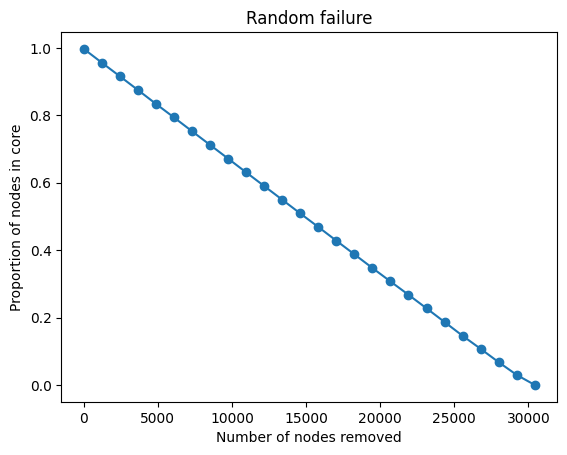

In [67]:
plt.title('Random failure')
plt.xlabel('Number of nodes removed')
plt.ylabel('Proportion of nodes in core')
plt.plot(num_nodes_removed, random_attack_core_proportions, marker='o')
del random_failure_graph

### Targeted Attacks on Degree Centrality

In [68]:
targeted_failure_graph = filtered_graph.copy()
number_of_nodes_removed_each_step = targeted_failure_graph.number_of_nodes() // number_of_steps

In [69]:
number_of_nodes = targeted_failure_graph.number_of_nodes()
targeted_attack_core_proportions = []
for nodes_removed in num_nodes_removed:
    core = next(nx.weakly_connected_components(targeted_failure_graph))
    core_proportion = len(core) / number_of_nodes
    targeted_attack_core_proportions.append(core_proportion)

    if targeted_failure_graph.number_of_nodes() > number_of_nodes_removed_each_step:
        nodes_to_remove = sorted(targeted_failure_graph, key=targeted_failure_graph.degree, reverse=True)[:number_of_nodes_removed_each_step]
        targeted_failure_graph.remove_nodes_from(nodes_to_remove)

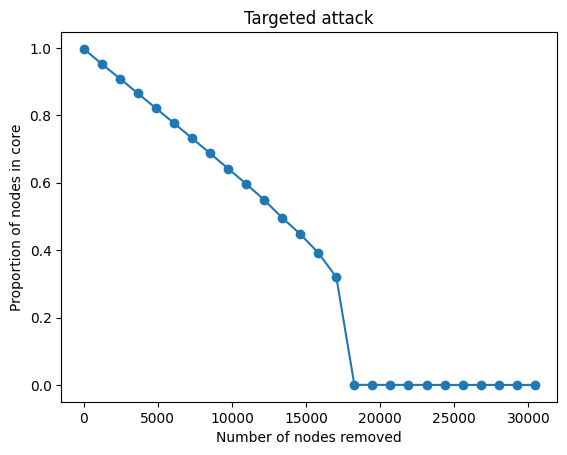

In [70]:
plt.title('Targeted attack')
plt.xlabel('Number of nodes removed')
plt.ylabel('Proportion of nodes in core')
plt.plot(num_nodes_removed, targeted_attack_core_proportions, marker='o')

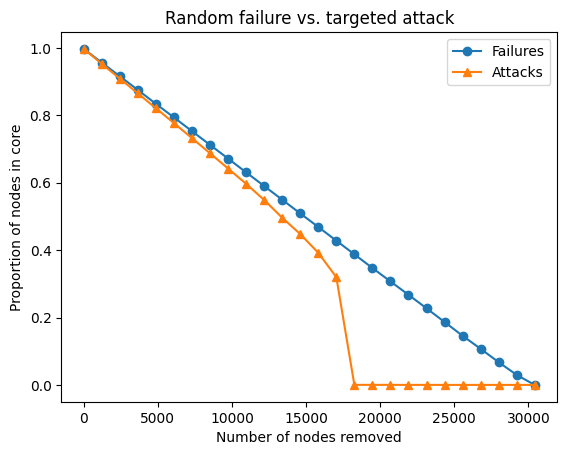

In [71]:
plt.title('Random failure vs. targeted attack')
plt.xlabel('Number of nodes removed')
plt.ylabel('Proportion of nodes in core')
plt.plot(num_nodes_removed, random_attack_core_proportions, color='tab:blue', marker='o', label='Failures')
plt.plot(num_nodes_removed, targeted_attack_core_proportions, color='tab:orange', marker='^', label='Attacks')
plt.legend()

## Community Detection

We have run three different community detection algorithms: **Clauset-Newman-Moore, Infomap, and Louvain**. These have produced **99, 436, and 285** communities respectively. Analysing the communities found by the community detection algorithms, there is a clear pattern: **communities within the speedrun.com network are created around individual games and games series**. We can see communities form around running racing games (infomap no.12), language of the game (louvain 4), the developer of the game (louvain 21), a series of games (louvain 27), the theme of super heros (louvain 70), a game series and their category extensions (louvain 88), or by platform (example tbf).

Focusing on the number of games and the number of total runs in a community, we see that **the largest communities in each of the three algorithms have a z-score of approximately 17.5, 10, and 16 respectively**. The largest communities also have what are called "typical speedrun games". **Typical speedrun games" are categorised by their extremely large number of runs**, and examples of these are **Super Mario 64, Super Mario Odyssey, Celeste, Cuphead, Getting Over It With Bennett Foddy, Portal, Super Mario Sunshine, The Legend of Zelda: Breath of the Wild**, etc.

### Louvain Communities

There are **285 communities** found this way.

In [6]:
games_metadata_df = pd.read_csv('../data/raw/srcom_games_with_metadata.csv')
games_metadata_df[['num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']] = games_metadata_df[['num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']].apply(pd.to_numeric)
games_metadata_df.rename(columns = {'game_id': 'id'}, inplace=True)

In [7]:
louvain_communities_df = pd.read_csv("../data/processed/games/communities/all_games_louvain_communities.csv").rename(columns = {'node_id': 'id'})
merged_df = games_metadata_df.merge(louvain_communities_df, on='id', how='inner')
merged_df[['id', 'game_name', 'community_num']].sort_values(by='community_num')

,id,game_name,community_num
2245,76r3x5l6,Spellbound Dizzy,0
26613,ldejp8x1,Cocoa 2: Twenty Four Hour Parsley People,0
199,m1m04362,Forbidden Forest,0
26759,268eyxk6,DRIFT!,0
1771,j1newl91,Magicland Dizzy,0
...,...,...,...
13723,kdkz722d,Numz,283
14048,3698oxld,Nimball: Rewind,283
10341,w6jlr7ed,Dobrynya Nikitich i Zmey Gorynych,284
11599,yd4o97w1,Il'ya Muromets i Solovey-Razboynik,284


In [8]:
merged_df.groupby('community_num').count().sort_values(by='id').tail().iloc[::-1][['id']].rename(columns={'id':'num_games_in_cluster'}).reset_index()

,community_num,num_games_in_cluster
0,23,16380
1,8,1924
2,16,1742
3,74,1207
4,38,1140


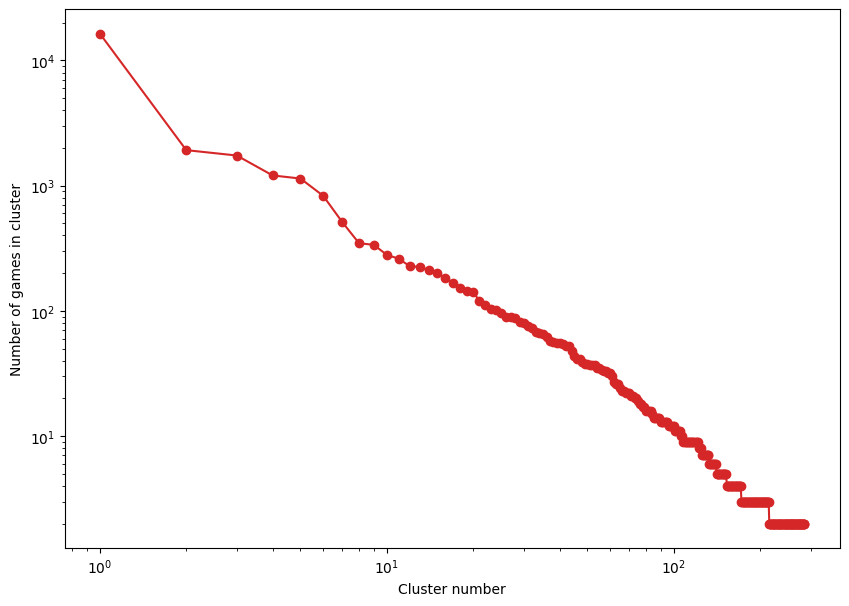

In [11]:
fig, ax = plt.subplots(1, 1)
_, counts = list(zip(*sorted(Counter(louvain_communities_df['community_num']).items(), key=itemgetter(1), reverse=True)))
x = [i for i in range(1, len(counts)+1)]
ax.loglog(x, counts, color='tab:red', marker='o')
ax.set_xlabel("Cluster number")
ax.set_ylabel("Number of games in cluster")

fig.set_figwidth(10)
fig.set_figheight(7)

plt.show()

In [20]:
zscore_df = merged_df.groupby('community_num').count().rename(columns={'id':'num_games'})[['num_games']]
zscore_df['zscore'] = (zscore_df['num_games'] - zscore_df['num_games'].mean()) / zscore_df['num_games'].std()
zscore_df.sort_values(by='zscore', ascending=False).head(60)

,num_games,zscore
community_num,,
23,16380,16.496155
8,1924,1.842091
16,1742,1.657597
74,1207,1.115267
38,1140,1.047349
29,830,0.733102
3,512,0.410745
68,347,0.243484
46,337,0.233347


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


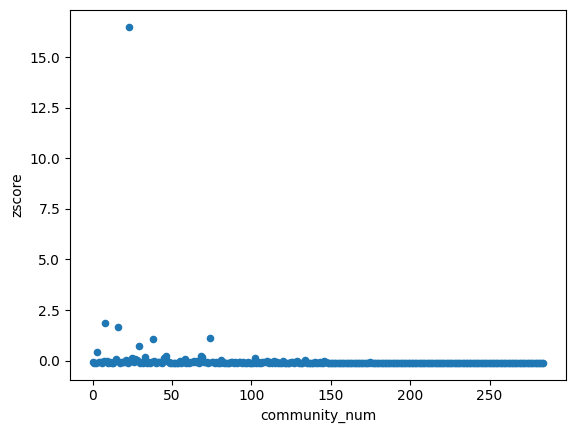

In [13]:
zscore_df.reset_index().plot.scatter(x='community_num', y='zscore')
plt.show()

In [58]:
zscore_df = merged_df.groupby('community_num').sum().rename(columns={'id':'num_games'})[['num_runs']]
zscore_df['zscore'] = (zscore_df['num_runs'] - zscore_df['num_runs'].mean()) / zscore_df['num_runs'].std()
zscore_df.sort_values(by='zscore', ascending=False).head()

,num_runs,zscore
community_num,,
23,1711567,16.252400
8,353083,3.268545
38,212575,1.925625
29,145230,1.281968
3,74142,0.602537


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


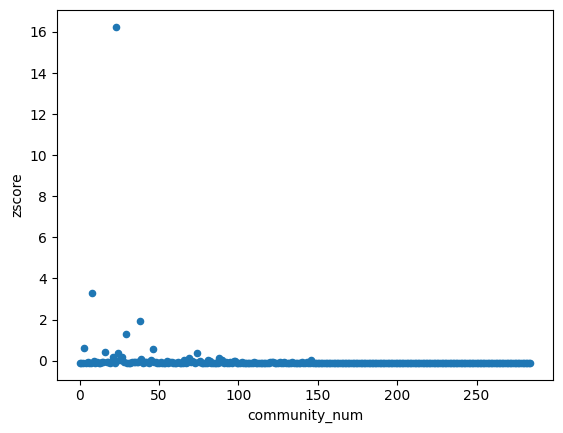

In [15]:
zscore_df.reset_index().plot.scatter(x='community_num', y='zscore')
plt.show()

In [24]:
game_ids = list(merged_df[(merged_df['community_num'] == 38)]['id'])
merged_df[(merged_df['id'].isin(game_ids))].sort_values(by='num_runs', ascending=False)['game_name'].values.tolist()

['Speed Builders',
 'Minecraft: Java Edition',
 'Minecraft: Java Edition Category Extensions',
 'ROBLOX: Speed Run 4',
 'Karlson (Itch.io)',
 'Hypixel Server Parkour',
 'Hypixel BedWars',
 'Minecraft (Classic)',
 'HiveMC DeathRun',
 'RE:RUN',
 'Happy Wheels',
 'CubeCraft Parkour',
 'The Henry Stickmin Collection',
 'Minecraft Hielke Maps',
 'Duck Life 1',
 'Speed Builders Turkey',
 'Choppy Orc',
 'Hypixel Category Extensions',
 'Hypixel SkyBlock',
 'Henry Stickmin Category Extensions',
 'Filtered Seed Glitchless',
 'Hypixel Duels',
 'Hypixel BedWars Category Extensions',
 'Dragon Escape',
 'Hypixel SkyWars',
 'Jelly Drift',
 'ROBLOX: BedWars',
 'Fireboy and Watergirl 1 - The Forest Temple',
 'McPlayHD',
 'Minecraft: Java Edition Unofficial Category Extensions',
 'HiveMC Dropper',
 'Papa Louie 2: When Burgers Attack!',
 'ROBLOX: Survive and Kill the Killers in Area 51',
 'Pixel Quest',
 'Hypixel Bridging',
 'Getting Over It (Scratch edition)',
 'Goime 500',
 'Age of History 2',
 'Hypixe

 * 0 - Dizzy game series, Jet Set Willy series, others
 * 1 - Chirpy Reverie series
 * 2 - Two horror games
 * 3 - Some ROBLOX games, random games
 * 4 - Games from Japan
 * 5 - Karting games (Markio Kart), games from Nintendo
 * 6 - ?
 * 7 - Pokemon Mystery Dungeons, I Spy series
 * 8 - Web games, Mobile Games, Roblox games, Dadish series, 
 * 9 - Need for speed series, driving games, driving simulation, card games
 * 10 - Random PC games?
 * 11 - F1 series, some other racing games
 * 12 - ?
 * 13 - Asterix series, European games, Kot Leopold (Leopold the cat), Garfield
 * 14 - Metal Gear Solid series, shooting games
 * 15 - More Pokemon Mystery Dungeons
 * 16 - ?
 * 17 - Starshine Legacy episodes
 * 18 - Transformers games, Mario vs. Donkey Kong games, LEGO games
 * 19 - ?
 * 20 - Bendy series, Minecraft Dungeons
 * 21 - Grand Theft Auto series, Rockstar Games, some FIFA games, Saints Row series, Football games
 * 22 - Simulation games
 * 23 - Nintendo games, 'typical speedrun' games, Valve games, popular games in general
 * 24 - Minecraft games
 * 25 - Granny series, Sonic games, web games, horror games
 * 26 - Doom games, other random games
 * 27 - LEGO games, Ben 10 games, old CoD games, Doctor Who games
 * 28 - ?
 * 29 - ROBLOX games, some Mario games, random games
 * 30 - ?
 * 31 - ?
 * 32 - Two random games
 * 33 - Super Mario World rom hacks
 * 34 - Moto X3M series, random games
 * 35 - ?
 * 36 - Rec Room series
 * 37 - Hello Neighbour series, horror games
 * 38 - Minecraft games, web games, some ROBLOX games, random other games
 * 39 - Red Ball series, Five Nights games
 * 40 - Robokill series
 * 41 - ?

### Greedy Modularity Communities

There are **99 communities** found this way.

In [17]:
games_metadata_df = pd.read_csv('../data/raw/srcom_games_with_metadata.csv')
games_metadata_df[['num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']] = games_metadata_df[['num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']].apply(pd.to_numeric)
games_metadata_df.rename(columns = {'game_id': 'id'}, inplace=True)

In [18]:
greedy_modularity_communities_df = pd.read_csv("../data/processed/games/communities/all_games_greedy_modularity_communities.csv").rename(columns = {'node_id': 'id'})
merged_df = games_metadata_df.merge(greedy_modularity_communities_df, on='id', how='inner')
merged_df[['id', 'game_name', 'community_num']].sort_values(by='community_num')

,id,game_name,community_num
0,j1n8nj91,Computer Space,0
17977,nd29y360,I Wanna Go The Floatkid,0
17976,o1y4nk1q,Plug & Play,0
29489,j1lq2rv6,Winter Ember,0
17973,y65kq86e,The Curse of Anubis,0
...,...,...,...
16709,k6qw22m6,Legend of Equip > Pants,96
20854,o6gl8e5d,Last Tale,97
21068,76rxlre6,HellGunner,97
13723,kdkz722d,Numz,98


In [19]:
merged_df.groupby('community_num').count().sort_values(by='id', ascending=False).head()[['id']].rename(columns={'id':'num_games_in_cluster'}).reset_index()

,community_num,num_games_in_cluster
0,0,24070
1,1,4653
2,2,1294
3,3,46
4,4,20


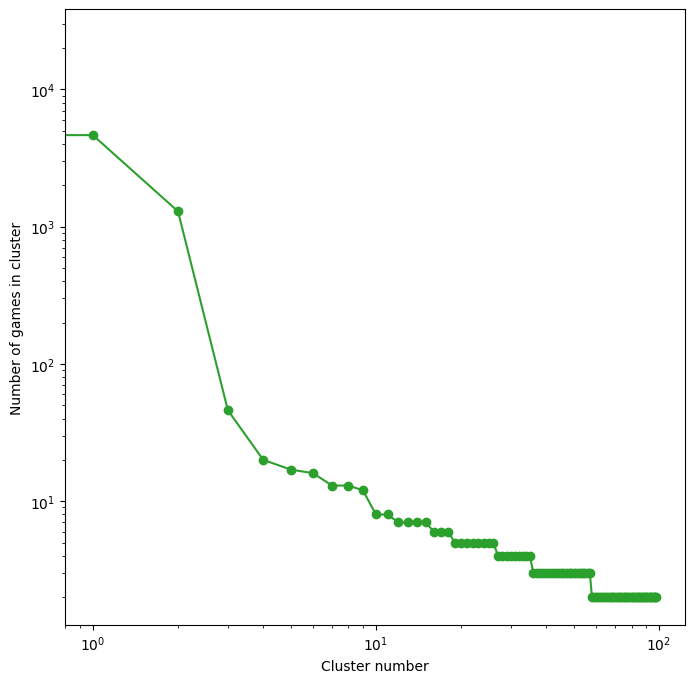

In [20]:
cluster_num, counts = list(zip(*sorted(Counter(greedy_modularity_communities_df['community_num']).items(), key=itemgetter(1), reverse=True)))

fig, ax = plt.subplots(1, 1)

ax.loglog(cluster_num, counts, color='tab:green', marker='o')
ax.set_xlabel("Cluster number")
ax.set_ylabel("Number of games in cluster")

fig.set_figwidth(8)
fig.set_figheight(8)

plt.show()

In [21]:
zscore_df = merged_df.groupby('community_num').count().rename(columns={'id': 'num_games'})[['num_games']]
zscore_df['zscore'] = (zscore_df['num_games'] -zscore_df['num_games'].mean()) / zscore_df['num_games'].std()
zscore_df.sort_values(by='zscore', ascending=False).head()

,num_games,zscore
community_num,,
0,24070,9.657299
1,4653,1.766060
2,1294,0.400933
3,46,-0.106266
4,20,-0.116832


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


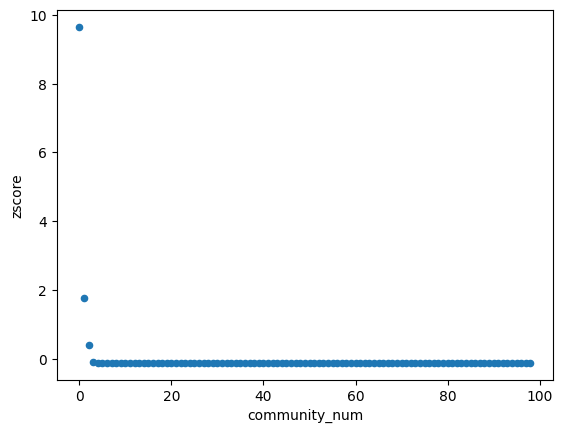

In [22]:
zscore_df.reset_index().plot.scatter(x='community_num', y='zscore')
plt.show()

In [23]:
zscore_df = merged_df.groupby('community_num').sum().rename(columns={'id': 'num_games'})[['num_runs']]
zscore_df['zscore'] = (zscore_df['num_runs'] -zscore_df['num_runs'].mean()) / zscore_df['num_runs'].std()
zscore_df.sort_values(by='zscore', ascending=False).head()

,num_runs,zscore
community_num,,
0,2507523,9.554785
1,625594,2.291236
2,25571,-0.024630
3,879,-0.119932
37,860,-0.120006


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


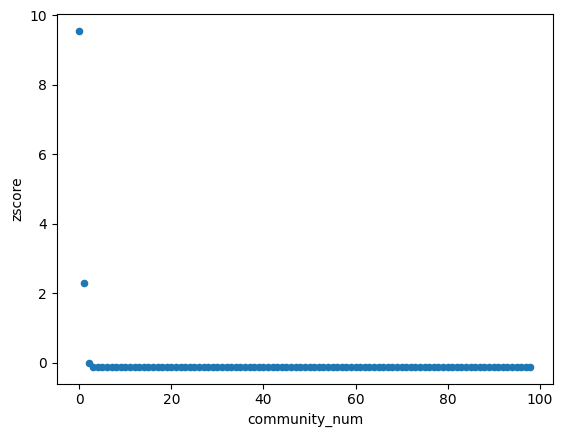

In [24]:
zscore_df.reset_index().plot.scatter(x='community_num', y='zscore')
plt.show()

In [25]:
game_ids = list(merged_df[(merged_df['community_num'] == 0)]['id'])
merged_df[(merged_df['id'].isin(game_ids))].sort_values(by='num_runs').tail(20).iloc[::-1]

,id,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests,community_num
4895,k6q4rqzd,Seterra,"4eppvoer,ne410dem",1997-01-01,2018-09-27T08:29:37Z,29,903,61962,7168,36,0
4671,o1y9wo6q,Super Mario 64,xv6dvx62,1996-06-23,None,6,15,33895,6118,452,0
22112,o1y9j9v6,Celeste,1zk4q26j,2018-01-25,2018-01-15T20:23:45Z,15,9,32317,5406,14,0
15305,yd478gde,Minecraft: Legacy Console Edition,"yzom2keq,yge00xep",2012-05-09,2015-01-29T23:42:25Z,11,12,19379,155,15646,0
14843,j1npme6p,Minecraft: Java Edition,k62d97ex,2011-11-18,2015-01-29T23:41:21Z,15,0,18329,6268,491,0
21733,76r55vd8,Super Mario Odyssey,xv6dvx62,2017-10-27,2017-09-27T00:35:19Z,6,0,17212,3790,45,0
21613,o1y9pyk6,Google Snake,pe1wp36o,2017-09-27,2020-01-19T12:16:58Z,11,32,17105,4236,8,0
21027,46w0n91r,Mario Kart 8 Deluxe,xv6dvx62,2017-04-28,2017-04-30T00:26:59Z,10,0,15196,3046,20,0
11395,4pd0n31e,Portal,leqm52zw,2007-10-09,None,7,24,13867,3448,65,0
21625,w6jmm26j,Cuphead,rzjkx7el,2017-09-29,2017-09-30T04:05:51Z,19,31,12221,1984,44,0


### Infomap Communities

There are **436 communities** generated using this method.

In [26]:
games_metadata_df = pd.read_csv('../data/raw/srcom_games_with_metadata.csv')
games_metadata_df[['num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']] = games_metadata_df[['num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']].apply(pd.to_numeric)
games_metadata_df.rename(columns = {'game_id': 'id'}, inplace=True)

In [27]:
infomap_communities_df = pd.read_csv("../data/processed/games/communities/all_games_infomap_communities.csv").rename(columns = {'node_id': 'id'})
merged_df = games_metadata_df.merge(infomap_communities_df, on='id', how='inner')
merged_df[['id', 'game_name', 'community_num']].sort_values(by='community_num', ascending=False)

,id,game_name,community_num
27551,268we5k6,The Lost Legends of Redwall: The Scout Act 2,435
21965,j1nel791,The Lost Legends of Redwall: The Scout Act 1,435
23134,3dx2q9p1,Into The Aether,434
28865,3dxkr8g1,AfterEffect DX: Directors Cut,434
12718,36989g2d,CID The Dummy,433
...,...,...,...
21435,y659q01e,DITCH SCHOOL TO GET RICH!! Adventure Obby,0
7646,nd28353d,Grimace's Shake Scramble,0
21429,kdkmqrq1,Once Upon a Tower,0
21428,w6j74326,LEGO Guesthouse Escape,0


In [28]:
merged_df.groupby('community_num').count().sort_values(by='id', ascending=False).head()[['id']].rename(columns={'id':'num_games_in_cluster'}).reset_index()

,community_num,num_games_in_cluster
0,0,6009
1,1,3628
2,2,1241
3,3,1118
4,4,629


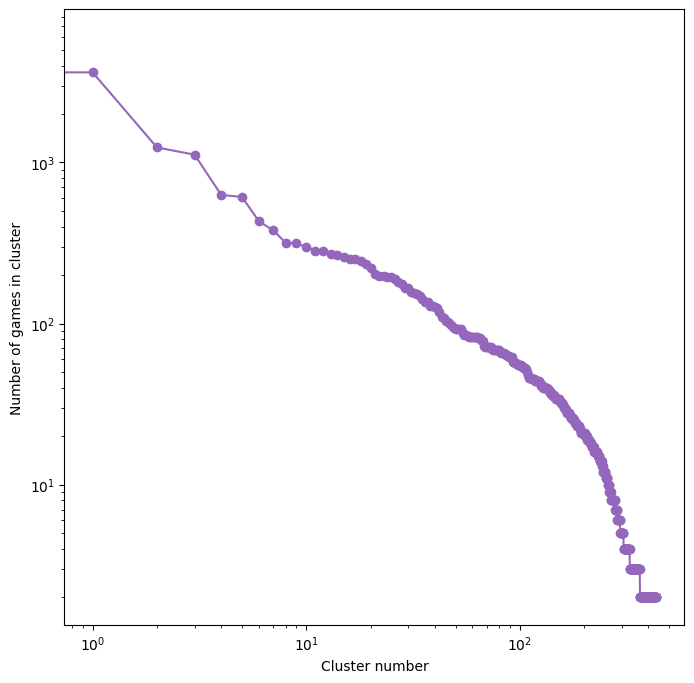

In [29]:
cluster_num, counts = list(zip(*sorted(Counter(infomap_communities_df['community_num']).items(), key=itemgetter(1), reverse=True)))

fig, ax = plt.subplots(1, 1)

ax.loglog(cluster_num, counts, color='tab:purple', marker='o')
ax.set_xlabel("Cluster number")
ax.set_ylabel("Number of games in cluster")

fig.set_figwidth(8)
fig.set_figheight(8)
plt.show()

In [30]:
zscore_df = merged_df.groupby('community_num').count().rename(columns={'id': 'num_games'})[['num_games']]
zscore_df['zscore'] = (zscore_df['num_games'] - zscore_df['num_games'].mean()) / zscore_df['num_games'].std()
zscore_df.sort_values(by='zscore', ascending=False).head()

,num_games,zscore
community_num,,
0,6009,17.006633
1,3628,10.188727
2,1241,3.353641
3,1118,3.001435
4,629,1.601201


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


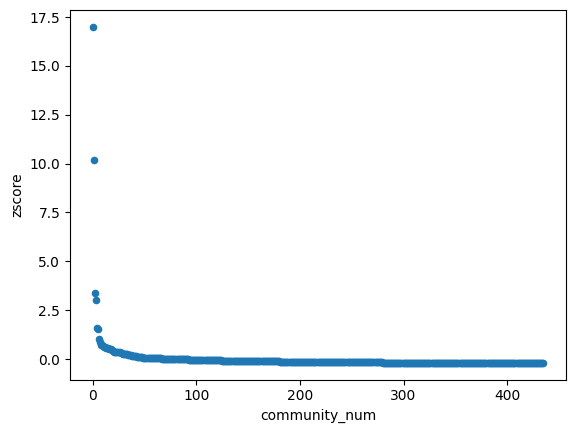

In [31]:
zscore_df.reset_index().plot.scatter(x='community_num', y='zscore')
plt.show()

In [32]:
zscore_df = merged_df.groupby('community_num').sum().rename(columns={'id': 'num_games'})[['num_runs']]
zscore_df['zscore'] = (zscore_df['num_runs'] - zscore_df['num_runs'].mean()) / zscore_df['num_runs'].std()
zscore_df.sort_values(by='zscore', ascending=False).head()

,num_runs,zscore
community_num,,
0,897408,18.386870
2,347766,7.033542
1,266802,5.361161
6,82790,1.560235
15,74191,1.382615


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1070: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


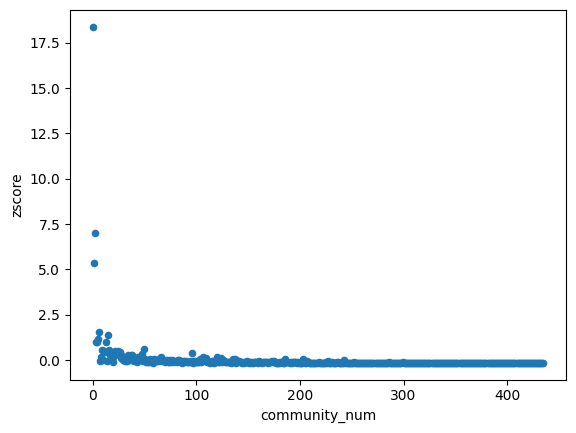

In [33]:
zscore_df.reset_index().plot.scatter(x='community_num', y='zscore')
plt.show()

In [34]:
game_ids = list(merged_df[(merged_df['community_num'] == 108)]['id'])
merged_df[(merged_df['id'].isin(game_ids))].sort_values(by='num_runs').tail(20).iloc[::-1]

,id,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests,community_num
26347,3dx24841,Genshin Impact,4ep0ddzr,2020-09-28,2020-10-02T22:31:03Z,12,29,1099,326,9,108
24611,j1n8p9e1,Mini Motorways,yz8jm96w,2019-09-19,2021-08-15T17:48:02Z,9,15,628,55,0,108
28896,j1n8y7w1,Vampire Survivors,None,2021-12-17,2022-02-05T21:19:19Z,6,14,509,55,0,108
22547,268evn56,Koloro,jevvrnek,2018-05-18,2019-01-29T03:11:29Z,4,105,226,9,0,108
28070,yd4k7g56,Doomori,ge0ln2ep,2021-08-06,2021-08-17T15:49:35Z,7,5,110,15,0,108
14075,j1nee5l1,Eggman Hates Furries,yzo7wkeq,2010-12-13,2018-01-06T00:31:01Z,4,21,109,2,0,108
29032,9d38l501,DOOMORI - ETERNAL,vegdmpe0,2022-01-15,2022-02-16T18:00:01Z,6,6,77,2,0,108
12027,pdvkvv6w,Space Chimps,"k6250d6x,mznd526r,k625q06x",2008-07-15,2016-08-05T06:49:37Z,5,12,67,2,0,108
29577,j1lqj976,Jaded [beta],rzj597el,2022-04-30,2022-05-13T13:28:21Z,9,4,60,13,0,108
28376,kdkm8521,Pullywog,rzjj3nzl,2021-09-28,2021-11-18T16:53:22Z,5,0,59,23,0,108


## Measuring Community Detection Performance

In [48]:
cluster_nums = louvain_communities_df['community_num'].unique()
louvain = []
for cluster_num in cluster_nums:
    tmp_cluster = list(louvain_communities_df[(louvain_communities_df['community_num'] == cluster_num)]['id'])
    louvain.append(tmp_cluster)

cluster_nums = greedy_modularity_communities_df['community_num'].unique()
clauset_newman_moore = []
for cluster_num in cluster_nums:
    tmp_cluster = list(greedy_modularity_communities_df[(greedy_modularity_communities_df['community_num'] == cluster_num)]['id'])
    clauset_newman_moore.append(tmp_cluster)

cluster_nums = infomap_communities_df['community_num'].unique()
infomap = []
for cluster_num in cluster_nums:
    tmp_cluster = list(infomap_communities_df[(infomap_communities_df['community_num'] == cluster_num)]['id'])
    infomap.append(tmp_cluster)

In [49]:
algorithms = ['clauset_newman_moore', 'louvain', 'infomap']
modularity = [nx.community.modularity(filtered_graph, eval(algorithm)) for algorithm in algorithms]
coverage, performance = map(list, zip(*[nx.community.partition_quality(filtered_graph, eval(algorithm)) for algorithm in algorithms]))

In [51]:
tmp_df = pd.DataFrame(columns=['modularity', 'coverage', 'performance'])
for index, name in enumerate(algorithms):
    tmp_df.loc[name] = [round(x, 3) for x in [modularity[index], coverage[index], performance[index]]]
tmp_df.loc['average'] = [round(tmp_df['modularity'].mean(), 3), round(tmp_df['coverage'].mean(), 3), round(tmp_df['performance'].mean(), 3)]
tmp_df

,modularity,coverage,performance
clauset_newman_moore,0.275,0.845,0.360
louvain,0.400,0.470,0.697
infomap,0.312,0.703,0.947
average,0.329,0.673,0.668


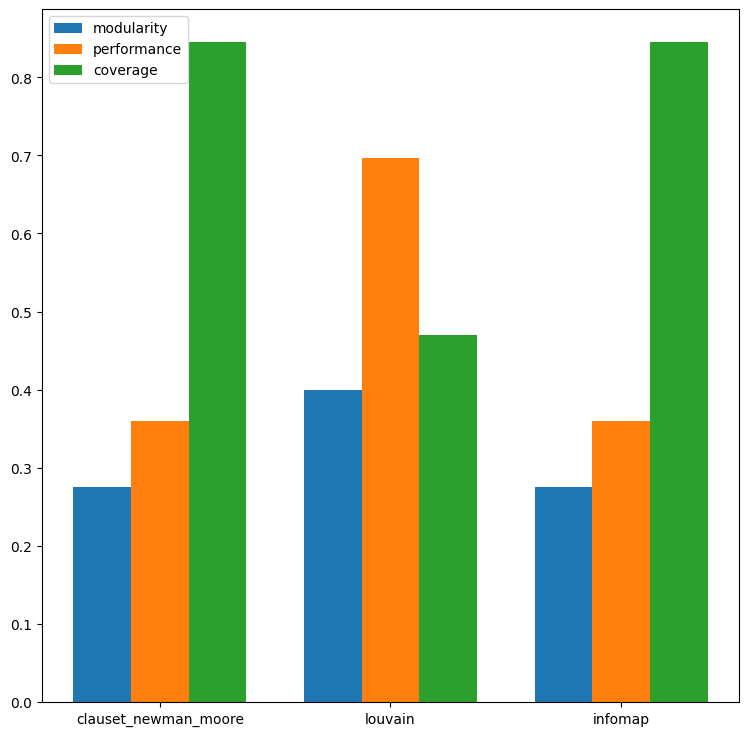

In [38]:
width = 0.25
ind = np.arange(len(algorithms))

fig, ax = plt.subplots(1, 1)

ax.bar(ind - width, modularity, width, label='modularity')
ax.bar(ind, performance, width, label='performance')
ax.bar(ind + width, coverage, width, label='coverage')
ax.legend(loc='best')
ax.set_xticks(ind, algorithms)

fig.set_figheight(9)
fig.set_figwidth(9)

plt.show()

In [108]:
del games_metadata_df, greedy_modularity_communities_df, merged_df, cluster_num, counts, louvain_communities_df, x, \
    cluster_nums, louvain, clauset_newman_moore, algorithms, modularity, performance, coverage